# Time series analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA

# Data

In [2]:
data= pd.read_csv("data4.csv", sep=';', header=None)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   object 
 1   1       1001 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [4]:
data.head()

0     1
0         NaN  0.00
1  2023-01-01  0.00
2  2023-01-02  0.59
3  2023-01-03 -0.24
4  2023-01-04  0.23

In [5]:
print(data.isnull().sum())

0    1
1    0
dtype: int64


In [6]:
data = data.iloc[1:].reset_index(drop=True) # rimuove prima riga con NaN

# Converte le colonne
data.iloc[:, 0] = pd.to_datetime(data.iloc[:, 0], errors="coerce")
data.iloc[:, 1] = pd.to_numeric(data.iloc[:, 1], errors="coerce")

# Rinomina le colonne
data.columns = ["date", "value"]

# Imposta l'indice
data = data.set_index("date")

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2023-01-01 to 2025-09-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB


In [8]:
data.head()

value
date             
2023-01-01   0.00
2023-01-02   0.59
2023-01-03  -0.24
2023-01-04   0.23
2023-01-05  -0.41

# Plot data

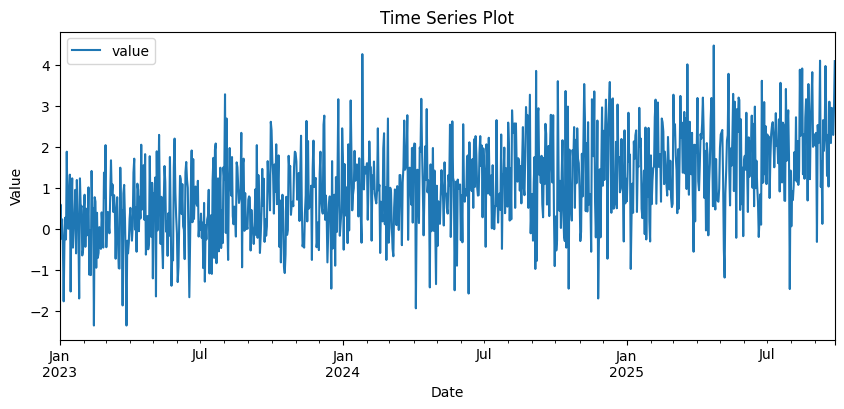

In [9]:
import matplotlib.pyplot as plt

data.plot(figsize=(10,4)) # grafico serie temporale
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Time Series Plot")
plt.show()

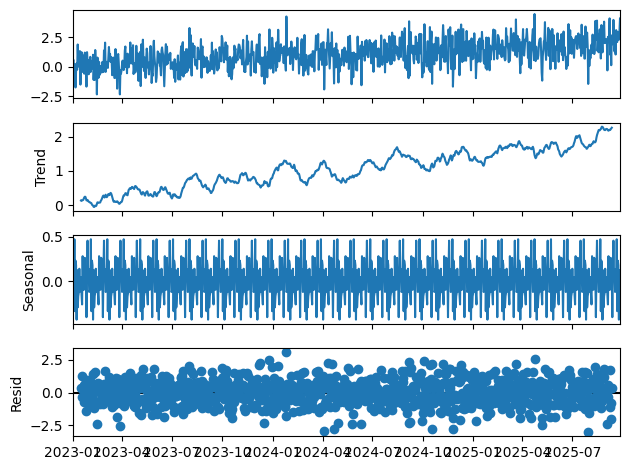

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data, model='additive', period=30) # stagionalità

fig = decomposition.plot()
plt.show()

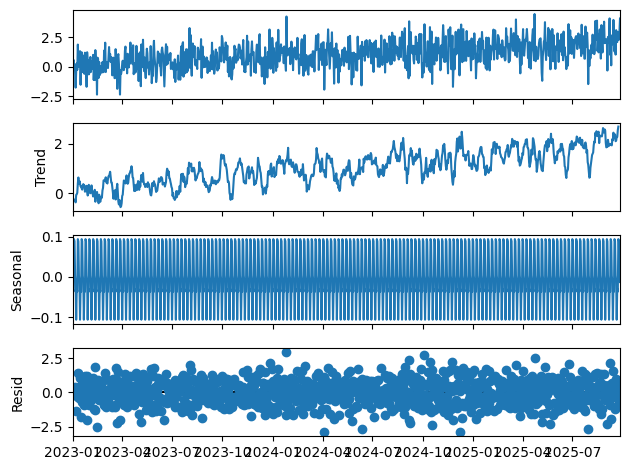

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data, model='additive', period=7) # stagionalità

fig = decomposition.plot()
plt.show()

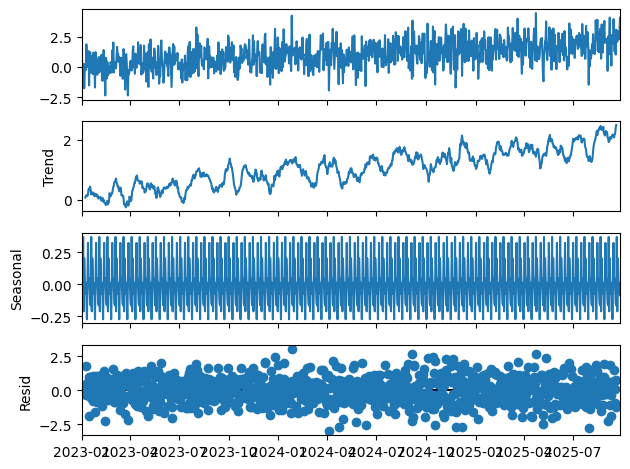

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data, model='additive', period=15) # stagionalità

fig = decomposition.plot()
plt.show()

# Stationarity


After performing the ADF and KPSS tests, the time series is not stationary. The time series needs to be differentiated to make it stationary.

Dopo aver eseguito i test ADF e KPSS, la serie temporale non risulta essere stazionaria. C'è bisgno di differenziare.

## ADF test

In [13]:
from statsmodels.tsa.stattools import adfuller

result_adftest = adfuller(data)

if result_adftest[1] < 0.05:
    print("➡️ La serie è stazionaria (rifiuto H0)")
else:
    print("➡️ La serie NON è stazionaria (non rifiuto H0)")

➡️ La serie NON è stazionaria (non rifiuto H0)


## KPSS test


In [14]:
# from statsmodels.tsa.stattools import kpss

kpss_result = kpss( data, regression='c', nlags='auto')


alpha = 0.05
if kpss_result[1] < alpha:
    print("➡️ La serie NON è stazionaria (rifiuto H0)")
else:
    print("➡️ La serie è stazionaria (non rifiuto H0)")

➡️ La serie NON è stazionaria (rifiuto H0)


/tmp/ipython-input-1552816881.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss( data, regression='c', nlags='auto')


##

## Seasonal Differentiation

The time series needs to be differentiated to make it stationary.

La differenziazione stagionale con periodi 7 e 15 ha reso la serie stazionaria. L'analisi degli ACF e PACF delle serie differenziate suggerisce la presenza di componenti AR e MA stagionali che dovranno essere considerati nella modellazione SARIMA.

In [15]:
# --- 1. Differenziazione stagionale ---

data_seasonal_diff = sm.tsa.statespace.tools.diff(
    data, k_diff=0, k_seasonal_diff=1, seasonal_periods=7 # stagionalità 7
)

In [16]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss( data_seasonal_diff, regression='c', nlags='auto')


alpha = 0.05
if kpss_result[1] < alpha:
    print("➡️ La serie NON è stazionaria (rifiuto H0)")
else:
    print("➡️ La serie è stazionaria (non rifiuto H0)")

➡️ La serie è stazionaria (non rifiuto H0)


/tmp/ipython-input-3856592675.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss( data_seasonal_diff, regression='c', nlags='auto')


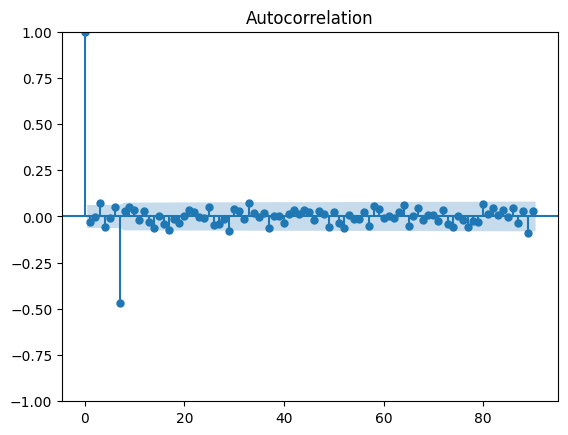

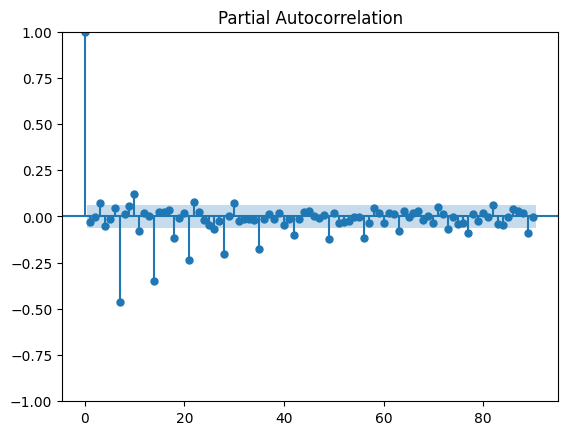

In [17]:
plot_acf(data_seasonal_diff, lags = 90)
plot_pacf(data_seasonal_diff, lags = 90)
plt.show()


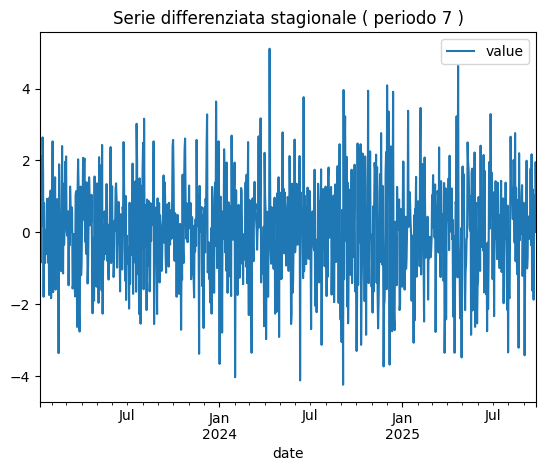

In [18]:
data_diff1 = data_seasonal_diff.dropna()
data_seasonal_diff.plot(title = "Serie differenziata stagionale ( periodo 7 )")
plt.show()

In [19]:

data_seasonal_diff_15 = sm.tsa.statespace.tools.diff(
    data, k_diff=0, k_seasonal_diff=1, seasonal_periods=15 # stagionalità 15
)

In [20]:
from statsmodels.tsa.stattools import kpss

kpss_result_15= kpss( data_seasonal_diff_15, regression='c', nlags='auto')


alpha = 0.05
if kpss_result_15[1] < alpha:
    print("➡️ La serie NON è stazionaria (rifiuto H0)")
else:
    print("➡️ La serie è stazionaria (non rifiuto H0)")

➡️ La serie è stazionaria (non rifiuto H0)


/tmp/ipython-input-490919107.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_15= kpss( data_seasonal_diff_15, regression='c', nlags='auto')


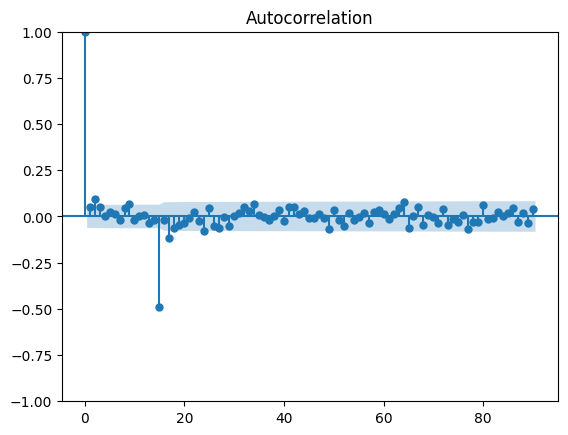

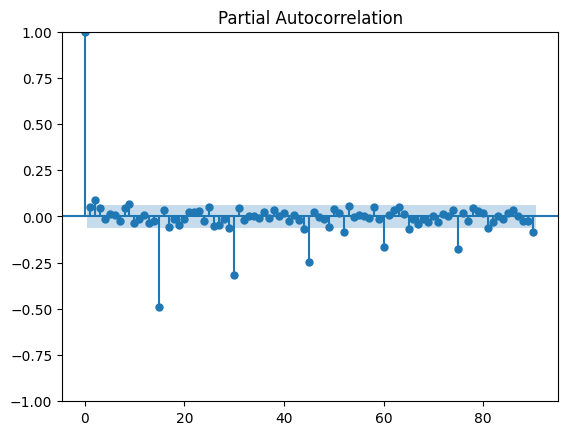

In [21]:
plot_acf(data_seasonal_diff_15, lags = 90)
plot_pacf(data_seasonal_diff_15, lags = 90)
plt.show()


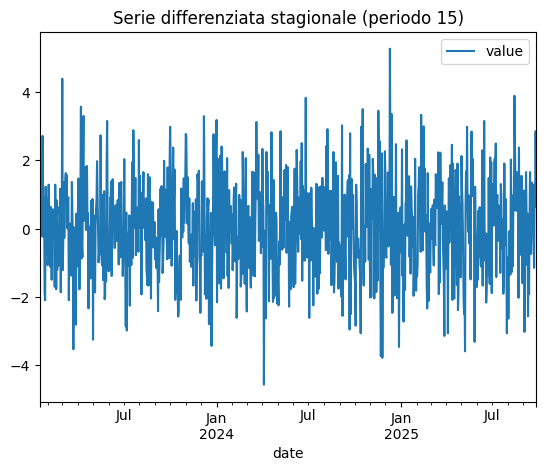

In [22]:
data_diff1_15 = data_seasonal_diff_15.dropna()
data_diff1_15.plot(title = "Serie differenziata stagionale (periodo 15)")
plt.show()

In [23]:
data_seasonal_diff_30 = sm.tsa.statespace.tools.diff(
    data, k_diff=0, k_seasonal_diff=1, seasonal_periods=30 # stagionalità 30
)

In [24]:
from statsmodels.tsa.stattools import kpss

kpss_result_30= kpss( data_seasonal_diff_30, regression='c', nlags='auto')


alpha = 0.05
if kpss_result_30[1] < alpha:
    print("➡️ La serie NON è stazionaria (rifiuto H0)")
else:
    print("➡️ La serie è stazionaria (non rifiuto H0)")

➡️ La serie è stazionaria (non rifiuto H0)


/tmp/ipython-input-4279396120.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_30= kpss( data_seasonal_diff_30, regression='c', nlags='auto')


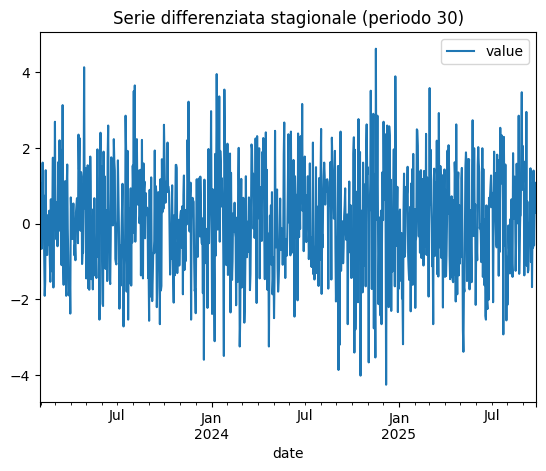

In [25]:
data_diff1_30 = data_seasonal_diff_30.dropna()
data_diff1_30.plot(title = "Serie differenziata stagionale (periodo 30)")
plt.show()

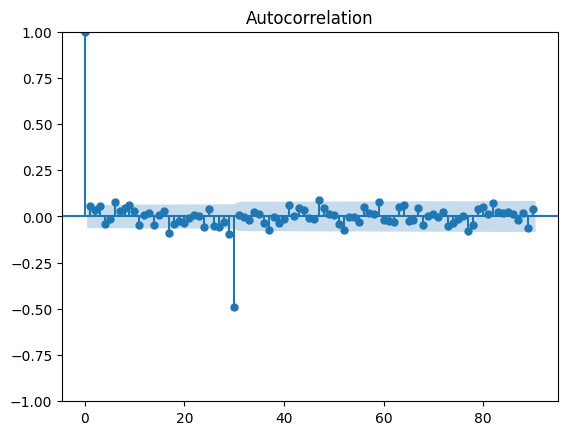

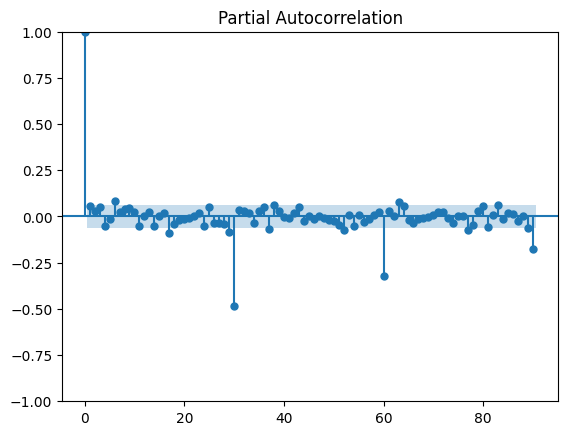

In [26]:
plot_acf(data_seasonal_diff_30, lags = 90)
plot_pacf(data_seasonal_diff_30, lags = 90)
plt.show()

# Model

## Analisi del Modello SARIMA(0,0,0)x(0,1,1,15)

In [27]:
sarima_000_011_15 = sm.tsa.SARIMAX(data, order=(0,0,0), seasonal_order=(0,1,1,15))
sarima_fit_000_011_15 = sarima_000_011_15.fit()
print(sarima_fit_000_011_15.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:                      value   No. Observations:                 1000
Model:             SARIMAX(0, 1, [1], 15)   Log Likelihood               -1447.251
Date:                    Tue, 30 Sep 2025   AIC                           2898.502
Time:                            14:35:16   BIC                           2908.287
Sample:                        01-01-2023   HQIC                          2902.223
                             - 09-26-2025                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L15      -0.8585      0.019    -45.087      0.000      -0.896      -0.821
sigma2         1.0837      0.049     21.939      0.000       0.987       1.180
Ljung-Box (L1) (Q): 

### Test dei Residui per SARIMA(0,0,0)x(0,1,1,15)

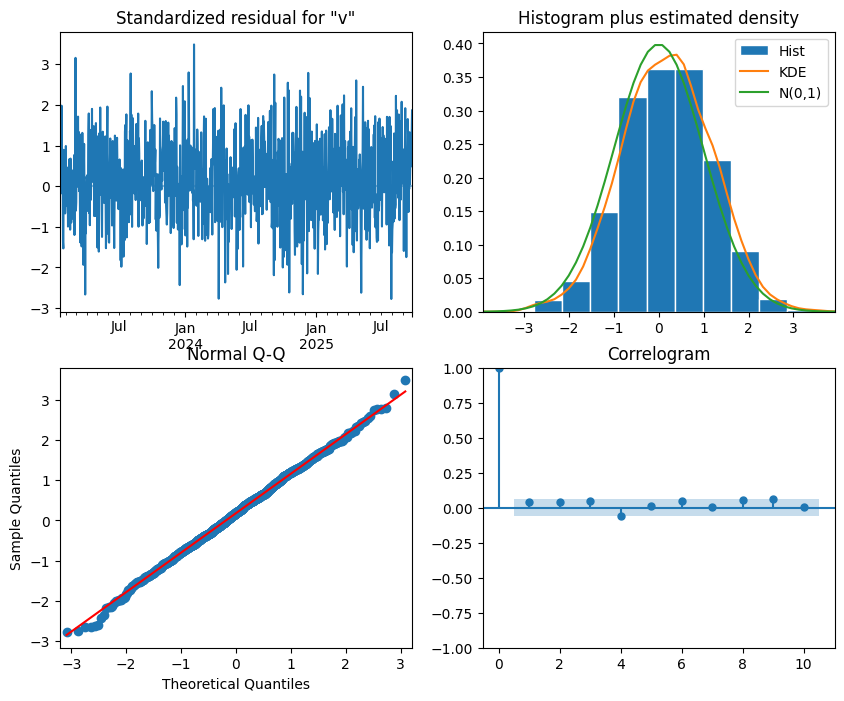

In [28]:
sarima_fit_000_011_15.plot_diagnostics(figsize=(10, 8))
plt.show()

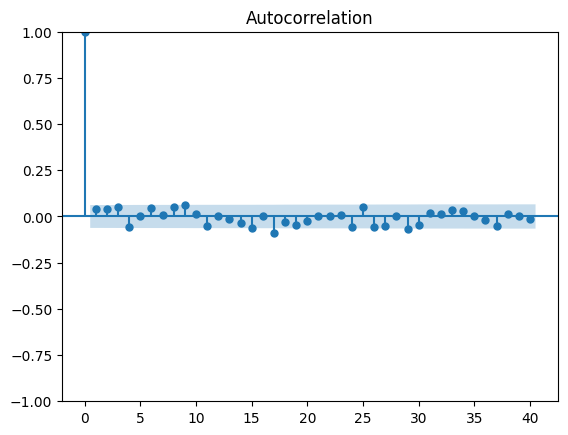

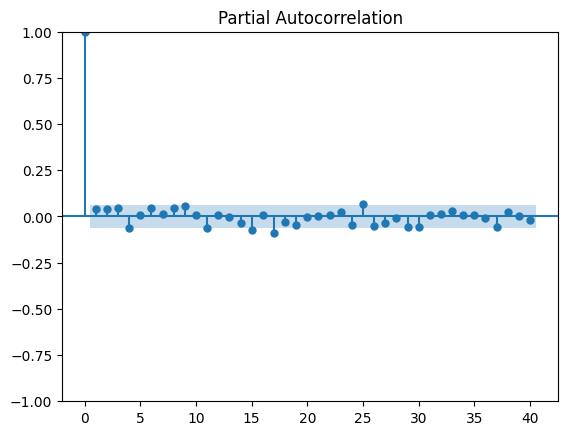

      lb_stat  lb_pvalue
10  18.136295   0.052708
20  38.238568   0.008280
30  58.036144   0.001581


In [29]:
residuals_sarima_000_011_15 = sarima_fit_000_011_15.resid
plot_acf(residuals_sarima_000_011_15, lags = 40)
plot_pacf(residuals_sarima_000_011_15, lags = 40)
plt.show()
lb_sarima_000_011_15  = acorr_ljungbox(residuals_sarima_000_011_15 , lags = [10,20,30], return_df = True)
print(lb_sarima_000_011_15)

## Analisi del Modello SARIMA(0,0,0)x(1,1,1,15)

In [30]:
sarima_000_111_15 = sm.tsa.SARIMAX(data, order=(0,0,0), seasonal_order=(1,1,1,15))
sarima_fit_000_111_15 = sarima_000_111_15.fit()
print(sarima_fit_000_111_15.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:                      value   No. Observations:                 1000
Model:             SARIMAX(1, 1, [1], 15)   Log Likelihood               -1447.104
Date:                    Tue, 30 Sep 2025   AIC                           2900.208
Time:                            14:35:20   BIC                           2914.885
Sample:                        01-01-2023   HQIC                          2905.790
                             - 09-26-2025                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L15      -0.0196      0.035     -0.556      0.578      -0.089       0.050
ma.S.L15      -0.8540      0.023    -37.434      0.000      -0.899      -0.809
sigma2         1.083

### Test dei Residui per SARIMA(0,0,0)x(1,1,1,15)

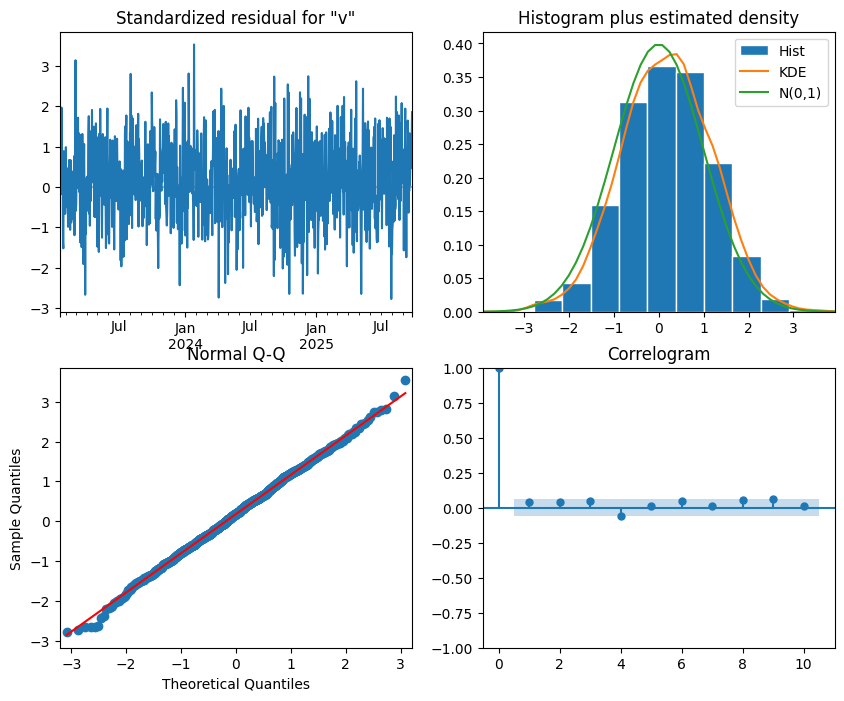

In [31]:
sarima_fit_000_111_15.plot_diagnostics(figsize=(10, 8))
plt.show()

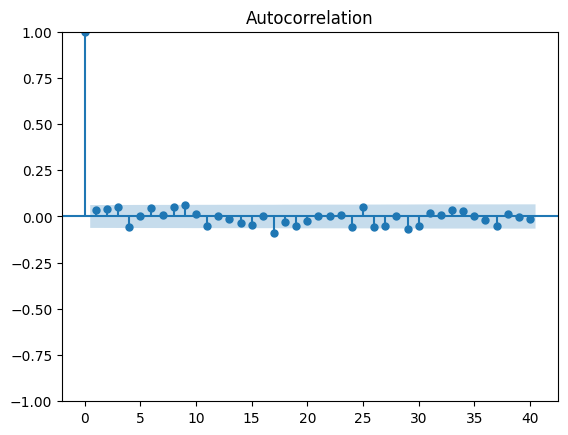

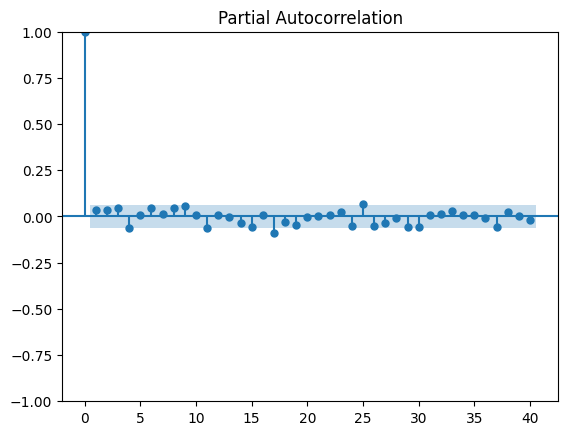

      lb_stat  lb_pvalue
10  18.351052   0.049323
20  36.923654   0.011951
30  57.193291   0.001986


In [32]:
residuals_sarima_000_111_15 = sarima_fit_000_111_15.resid
plot_acf(residuals_sarima_000_111_15, lags = 40)
plot_pacf(residuals_sarima_000_111_15, lags = 40)
plt.show()
lb_sarima_000_111_15  = acorr_ljungbox(residuals_sarima_000_111_15 , lags = [10,20,30], return_df = True)
print(lb_sarima_000_111_15)

## Analisi del Modello SARIMA(0,0,1)x(0,1,1,15)

In [33]:
sarima_001_011_15 = sm.tsa.SARIMAX(data, order=(0,0,1), seasonal_order=(0,1,1,15))
sarima_fit_001_011_15 = sarima_001_011_15.fit()
print(sarima_fit_001_011_15.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                 1000
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 15)   Log Likelihood               -1445.078
Date:                            Tue, 30 Sep 2025   AIC                           2896.155
Time:                                    14:35:23   BIC                           2910.833
Sample:                                01-01-2023   HQIC                          2901.738
                                     - 09-26-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0633      0.031      2.038      0.042       0.002       0.124
ma.S.L15      -0.8634      0.019   

### Test dei Residui per SARIMA(0,0,1)x(0,1,1,15)

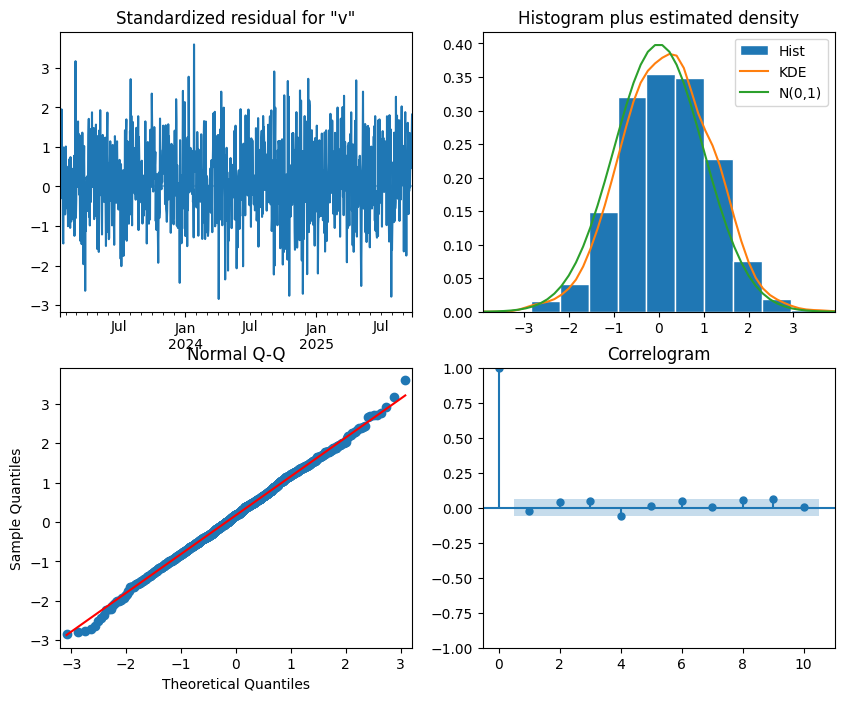

In [34]:
sarima_fit_001_011_15.plot_diagnostics(figsize=(10, 8))
plt.show()

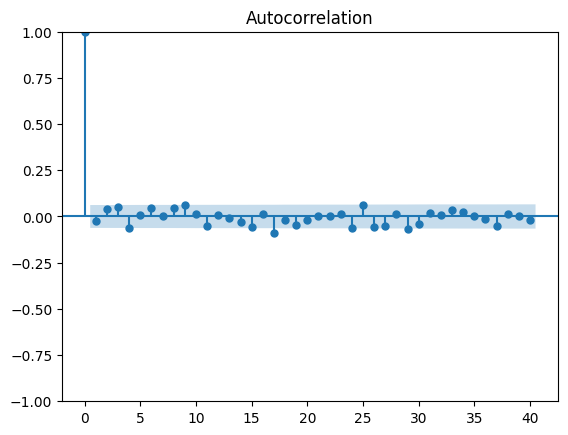

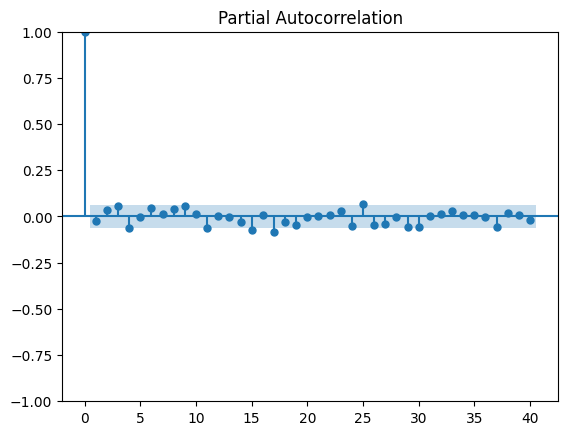

      lb_stat  lb_pvalue
10  16.860606   0.077506
20  35.614627   0.017065
30  55.939264   0.002775


In [35]:
residuals_sarima_001_011_15 = sarima_fit_001_011_15.resid
plot_acf(residuals_sarima_001_011_15, lags = 40)
plot_pacf(residuals_sarima_001_011_15, lags = 40)
plt.show()
lb_sarima_001_011_15  = acorr_ljungbox(residuals_sarima_001_011_15 , lags = [10,20,30], return_df = True)
print(lb_sarima_001_011_15)

## Analisi del Modello SARIMA(0,0,2)x(0,1,1,15)

In [36]:
sarima_002_011_15 = sm.tsa.SARIMAX(data, order=(0,0,2), seasonal_order=(0,1,1,15))
sarima_fit_002_011_15 = sarima_002_011_15.fit()
print(sarima_fit_002_011_15.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                 1000
Model:             SARIMAX(0, 0, 2)x(0, 1, [1], 15)   Log Likelihood               -1442.666
Date:                              Tue, 30 Sep 2025   AIC                           2893.333
Time:                                      14:35:27   BIC                           2912.904
Sample:                                  01-01-2023   HQIC                          2900.777
                                       - 09-26-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0576      0.031      1.851      0.064      -0.003       0.119
ma.L2          0.07

### Test dei Residui per SARIMA(0,0,2)x(0,1,1,15)

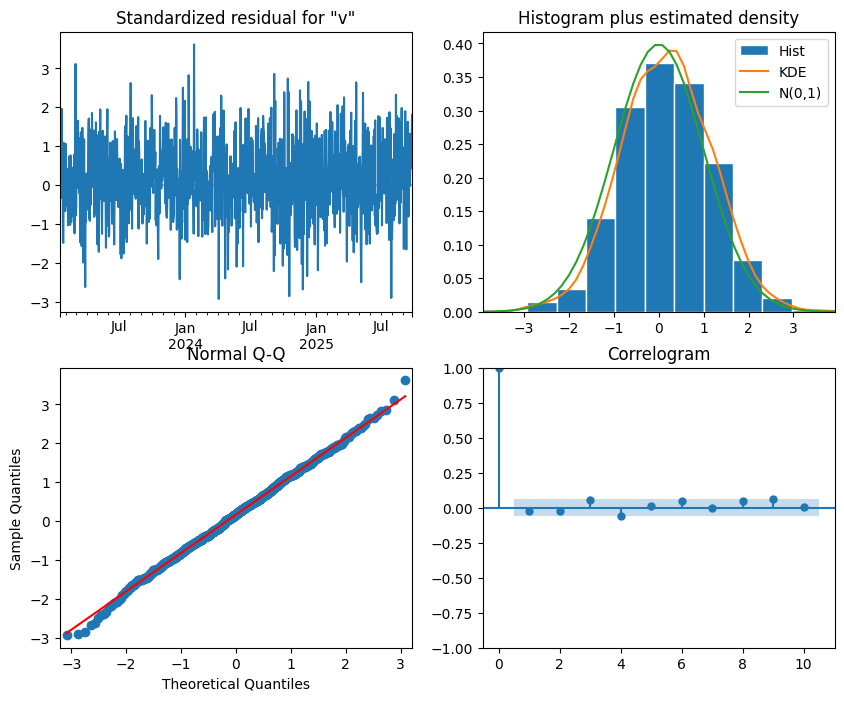

In [37]:
sarima_fit_002_011_15.plot_diagnostics(figsize=(10, 8))
plt.show()

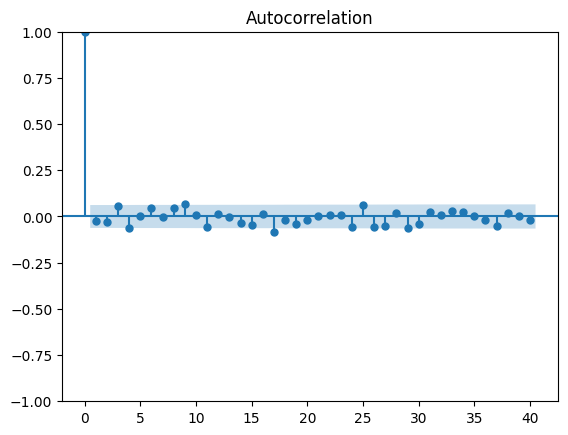

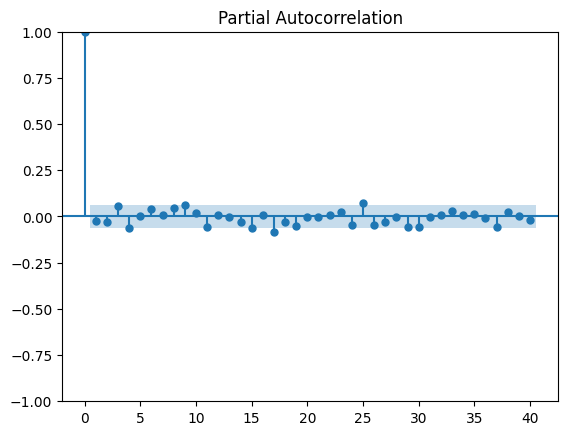

      lb_stat  lb_pvalue
10  17.173307   0.070616
20  33.765344   0.027757
30  53.487972   0.005240


In [38]:
residuals_sarima_002_011_15 = sarima_fit_002_011_15.resid
plot_acf(residuals_sarima_002_011_15, lags = 40)
plot_pacf(residuals_sarima_002_011_15, lags = 40)
plt.show()
lb_sarima_002_011_15  = acorr_ljungbox(residuals_sarima_002_011_15 , lags = [10,20,30], return_df = True)
print(lb_sarima_002_011_15)

## Analisi del Modello SARIMA(0,0,3)x(0,1,1,15)

In [39]:
sarima_003_011_15 = sm.tsa.SARIMAX(data, order=(0,0,3), seasonal_order=(0,1,1,15))
sarima_fit_003_011_15 = sarima_003_011_15.fit()
print(sarima_fit_003_011_15.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                 1000
Model:             SARIMAX(0, 0, 3)x(0, 1, [1], 15)   Log Likelihood               -1439.693
Date:                              Tue, 30 Sep 2025   AIC                           2889.386
Time:                                      14:35:32   BIC                           2913.849
Sample:                                  01-01-2023   HQIC                          2898.690
                                       - 09-26-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0711      0.031      2.299      0.022       0.010       0.132
ma.L2          0.07

### Test dei Residui per SARIMA(0,0,3)x(0,1,1,15)

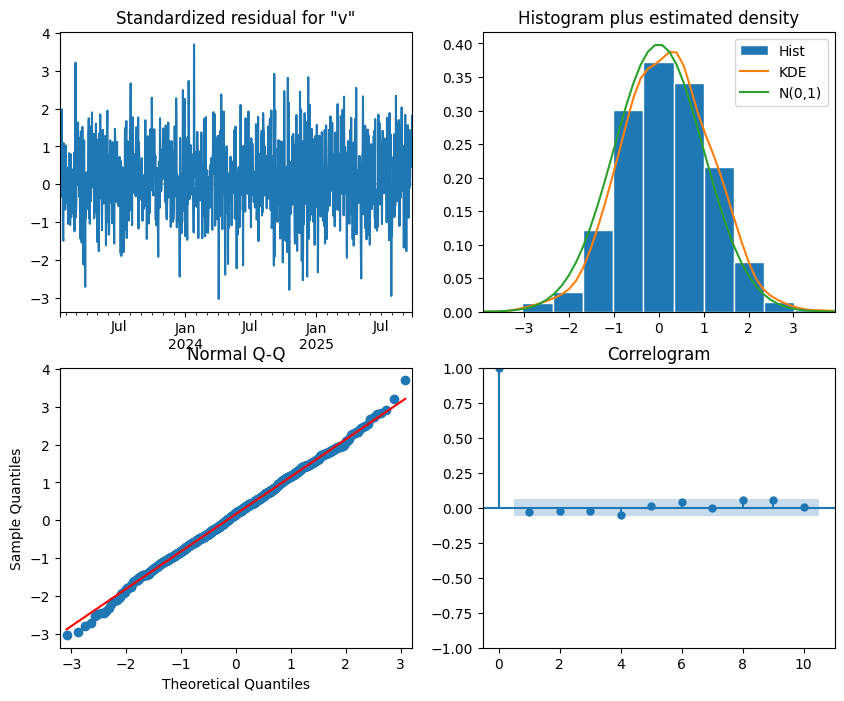

In [40]:
sarima_fit_003_011_15.plot_diagnostics(figsize=(10, 8))
plt.show()

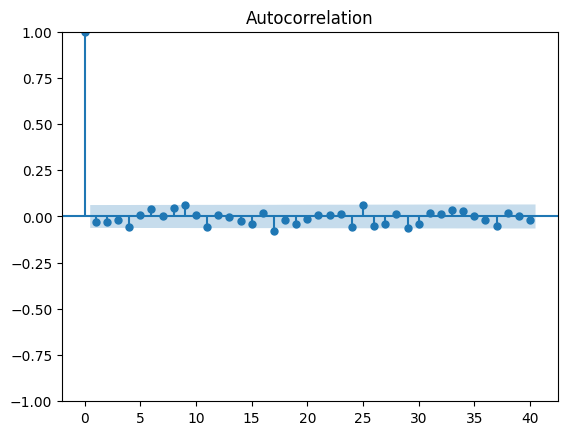

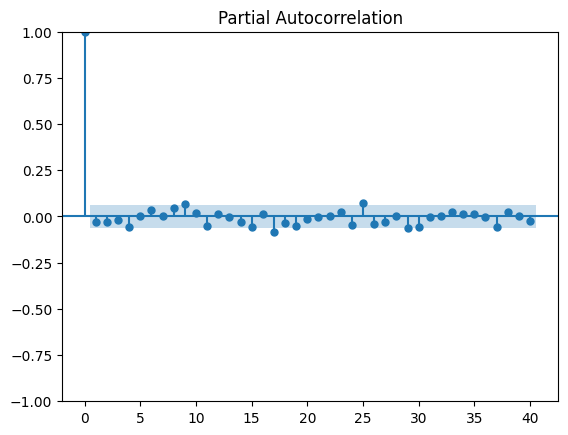

      lb_stat  lb_pvalue
10  12.931383   0.227534
20  28.116530   0.106669
30  45.662752   0.033453


In [41]:
residuals_sarima_003_011_15 = sarima_fit_003_011_15.resid
plot_acf(residuals_sarima_003_011_15, lags = 40)
plot_pacf(residuals_sarima_003_011_15, lags = 40)
plt.show()
lb_sarima_003_011_15  = acorr_ljungbox(residuals_sarima_003_011_15 , lags = [10,20,30], return_df = True)
print(lb_sarima_003_011_15)

## Analisi del Modello SARIMA(0,1,3)x(0,1,1,15)

In [42]:
sarima_013_011_15 = sm.tsa.SARIMAX(data, order=(0,1,3), seasonal_order=(0,1,1,15))
sarima_fit_013_011_15 = sarima_013_011_15.fit()
print(sarima_fit_013_011_15.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                 1000
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 15)   Log Likelihood               -1417.323
Date:                              Tue, 30 Sep 2025   AIC                           2844.646
Time:                                      14:35:46   BIC                           2869.104
Sample:                                  01-01-2023   HQIC                          2853.949
                                       - 09-26-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9746      0.205     -4.751      0.000      -1.377      -0.573
ma.L2          0.01

### Test dei Residui per SARIMA(0,1,3)x(0,1,1,15)

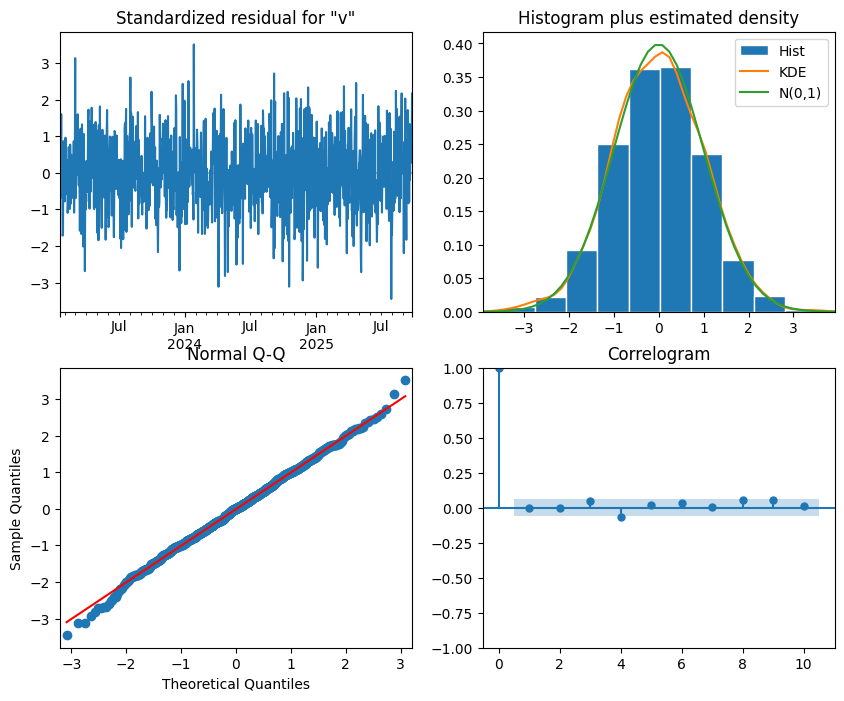

In [43]:
sarima_fit_013_011_15.plot_diagnostics(figsize=(10, 8))
plt.show()

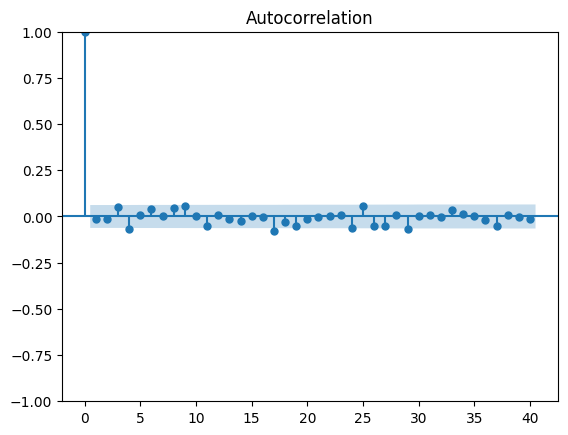

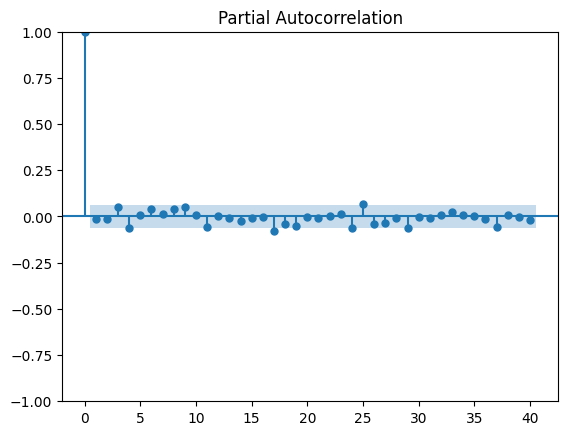

      lb_stat  lb_pvalue
10  14.483522   0.152057
20  28.822151   0.091321
30  47.276775   0.023378


In [44]:
residuals_sarima_013_011_15 = sarima_fit_013_011_15.resid
plot_acf(residuals_sarima_013_011_15, lags = 40)
plot_pacf(residuals_sarima_013_011_15, lags = 40)
plt.show()
lb_sarima_013_011_15  = acorr_ljungbox(residuals_sarima_013_011_15 , lags = [10,20,30], return_df = True)
print(lb_sarima_013_011_15)

## Analisi del Modello SARIMA(0,1,1)x(0,1,1,15)

In [45]:
sarima_011_011_15 = sm.tsa.SARIMAX(data, order=(0,1,1), seasonal_order=(0,1,1,15))
sarima_fit_011_011_15 = sarima_011_011_15.fit()
print(sarima_fit_011_011_15.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                 1000
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 15)   Log Likelihood               -1418.474
Date:                            Tue, 30 Sep 2025   AIC                           2842.948
Time:                                    14:35:54   BIC                           2857.623
Sample:                                01-01-2023   HQIC                          2848.530
                                     - 09-26-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998      0.251     -3.980      0.000      -1.492      -0.507
ma.S.L15      -0.9996      1.258   

### Test dei Residui per SARIMA(0,1,1)x(0,1,1,15)

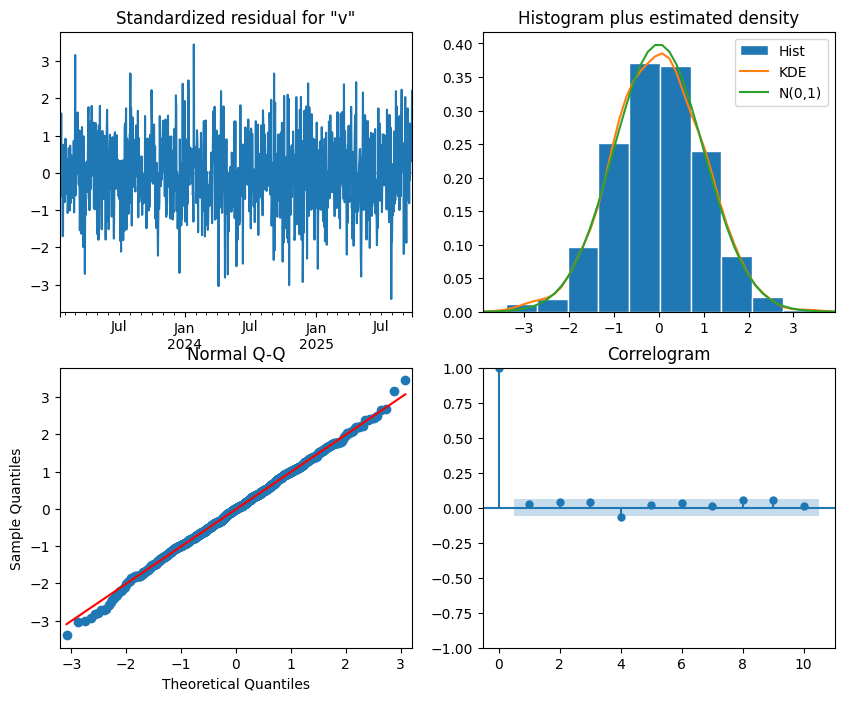

In [46]:
sarima_fit_011_011_15.plot_diagnostics(figsize=(10, 8))
plt.show()

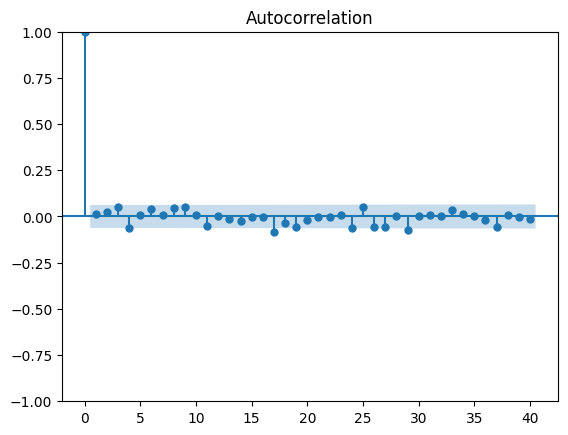

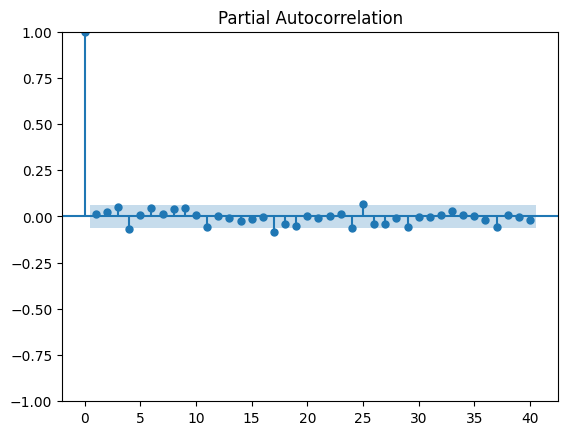

      lb_stat  lb_pvalue
10  14.926410   0.134768
20  30.447916   0.062914
30  49.068978   0.015465


In [47]:
residuals_sarima_011_011_15 = sarima_fit_011_011_15.resid
plot_acf(residuals_sarima_011_011_15, lags = 40)
plot_pacf(residuals_sarima_011_011_15, lags = 40)
plt.show()
lb_sarima_011_011_15  = acorr_ljungbox(residuals_sarima_011_011_15 , lags = [10,20,30], return_df = True)
print(lb_sarima_011_011_15)

In [48]:
sarima_111_011_15 = sm.tsa.SARIMAX(data, order=(1,1,1), seasonal_order=(0,1,1,15))
sarima_fit_111_011_15 = sarima_111_011_15.fit()
print(sarima_fit_111_011_15.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                 1000
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 15)   Log Likelihood               -1418.034
Date:                            Tue, 30 Sep 2025   AIC                           2844.067
Time:                                    14:36:03   BIC                           2863.634
Sample:                                01-01-2023   HQIC                          2851.510
                                     - 09-26-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0300      0.032      0.944      0.345      -0.032       0.092
ma.L1         -0.9999      0.763   

## Analisi del Modello SARIMA(0,1,1)x(0,1,1,7)

In [49]:
sarima_011_011_7 = sm.tsa.SARIMAX(data, order=(0,1,1), seasonal_order=(0,1,1,7))
sarima_fit_011_011_7 = sarima_011_011_7.fit()
print(sarima_fit_011_011_7.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                 1000
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1425.497
Date:                           Tue, 30 Sep 2025   AIC                           2856.994
Time:                                   14:36:05   BIC                           2871.693
Sample:                               01-01-2023   HQIC                          2862.583
                                    - 09-26-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9993      0.055    -18.220      0.000      -1.107      -0.892
ma.S.L7       -0.9988      0.091    -10.977

### Test dei Residui per SARIMA(0,1,1)x(0,1,1,7)

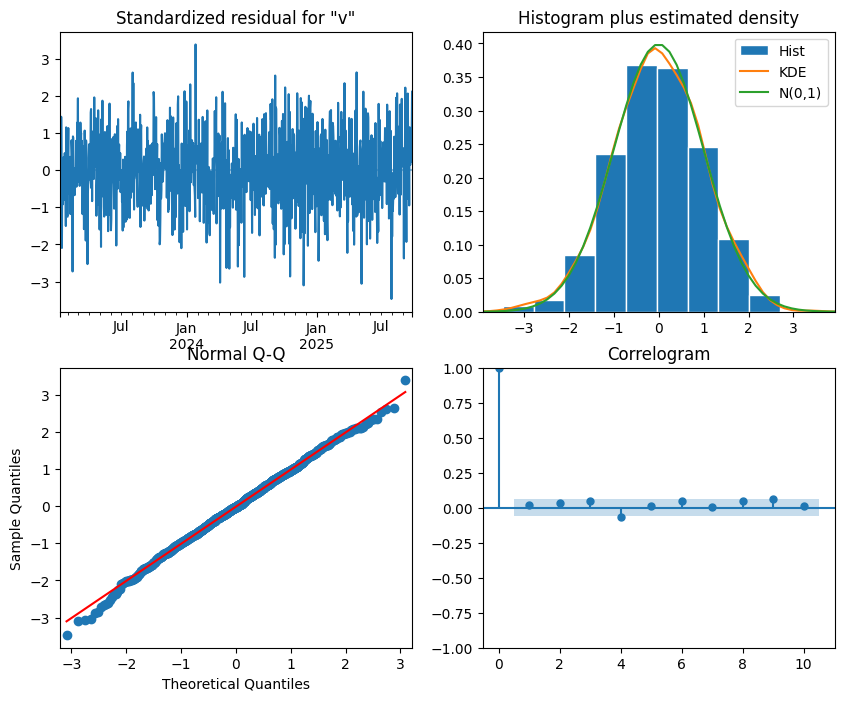

In [50]:
sarima_fit_011_011_7.plot_diagnostics(figsize=(10, 8))
plt.show()

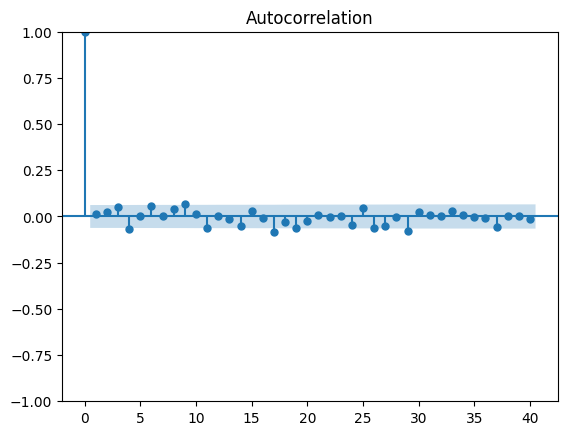

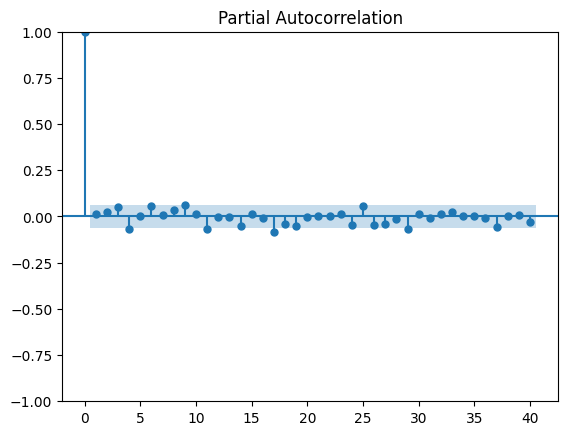

      lb_stat  lb_pvalue
10  17.766134   0.059039
20  38.741901   0.007178
30  56.818313   0.002196


In [51]:
residuals_sarima_011_011_7 = sarima_fit_011_011_7.resid
plot_acf(residuals_sarima_011_011_7, lags = 40)
plot_pacf(residuals_sarima_011_011_7, lags = 40)
plt.show()
lb_sarima_011_011_7  = acorr_ljungbox(residuals_sarima_011_011_7 , lags = [10,20,30], return_df = True)
print(lb_sarima_011_011_7)

In [52]:
## Analisi del Modello SARIMA(0,1,2)x(0,1,1,7)

In [53]:
sarima_012_011_7 = sm.tsa.SARIMAX(data, order=(0,1,2), seasonal_order=(0,1,1,7))
sarima_fit_012_011_7 = sarima_012_011_7.fit()
print(sarima_fit_012_011_7.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                 1000
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -1425.323
Date:                             Tue, 30 Sep 2025   AIC                           2858.646
Time:                                     14:36:09   BIC                           2878.245
Sample:                                 01-01-2023   HQIC                          2866.098
                                      - 09-26-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9819      0.574     -1.710      0.087      -2.107       0.143
ma.L2         -0.0180      

### Test dei Residui per SARIMA(0,1,2)x(0,1,1,7)

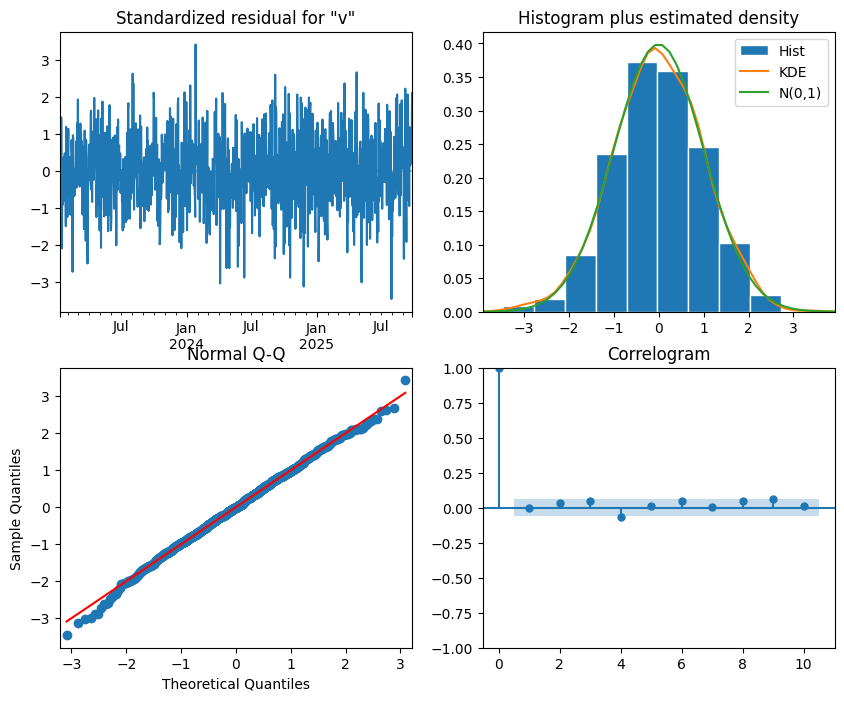

In [54]:
sarima_fit_012_011_7.plot_diagnostics(figsize=(10, 8))
plt.show()

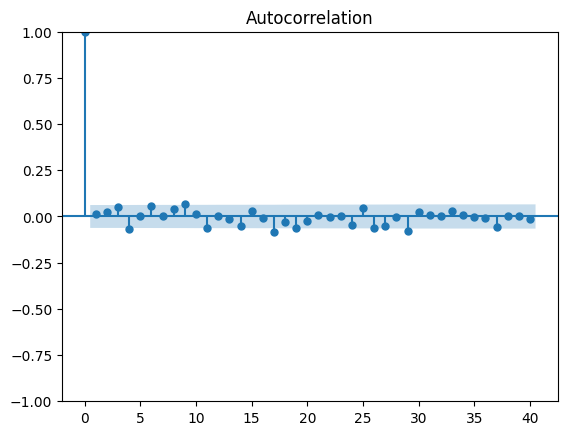

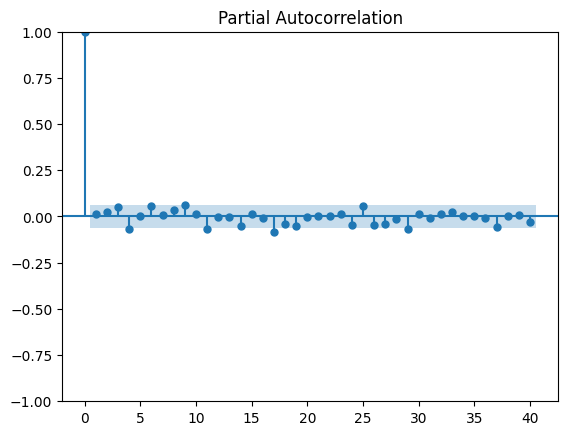

      lb_stat  lb_pvalue
10  17.766134   0.059039
20  38.741901   0.007178
30  56.818313   0.002196


In [55]:
residuals_sarima_012_011_7 = sarima_fit_011_011_7.resid
plot_acf(residuals_sarima_012_011_7, lags = 40)
plot_pacf(residuals_sarima_012_011_7, lags = 40)
plt.show()
lb_sarima_012_011_7  = acorr_ljungbox(residuals_sarima_012_011_7 , lags = [10,20,30], return_df = True)
print(lb_sarima_012_011_7)

## Analisi del Modello SARIMA(0,1,1)x(1,1,1,7)

In [56]:
sarima_011_111_7 = sm.tsa.SARIMAX(data, order=(0,1,1), seasonal_order=(1,1,1,7))
sarima_fit_011_111_7 = sarima_011_111_7.fit()
print(sarima_fit_011_111_7.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                 1000
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1425.438
Date:                           Tue, 30 Sep 2025   AIC                           2858.876
Time:                                   14:36:15   BIC                           2878.475
Sample:                               01-01-2023   HQIC                          2866.328
                                    - 09-26-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9997      0.139     -7.182      0.000      -1.273      -0.727
ar.S.L7        0.0107      0.032      0.336

### Test dei Residui per SARIMA(0,1,1)x(1,1,1,7)

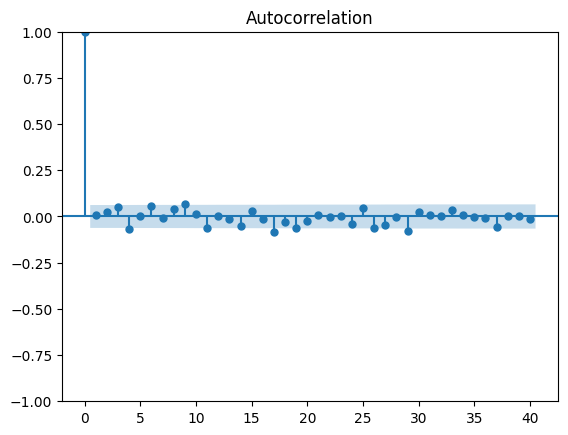

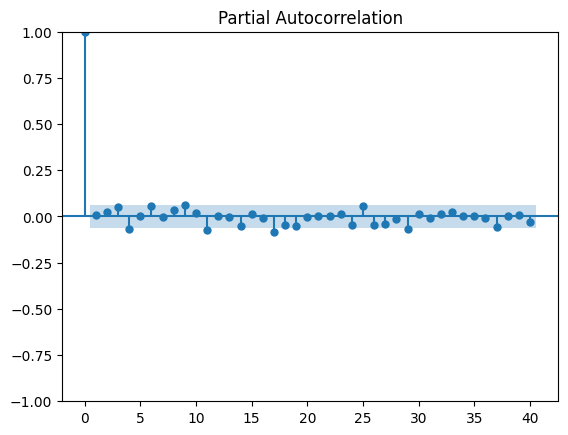

      lb_stat  lb_pvalue
10  17.739772   0.059515
20  38.429952   0.007843
30  56.390200   0.002462


In [57]:
residuals_sarima_011_111_7 = sarima_fit_011_111_7.resid
plot_acf(residuals_sarima_011_111_7, lags = 40)
plot_pacf(residuals_sarima_011_111_7, lags = 40)
plt.show()
lb_sarima_011_111_7  = acorr_ljungbox(residuals_sarima_011_111_7 , lags = [10,20,30], return_df = True)
print(lb_sarima_011_111_7)

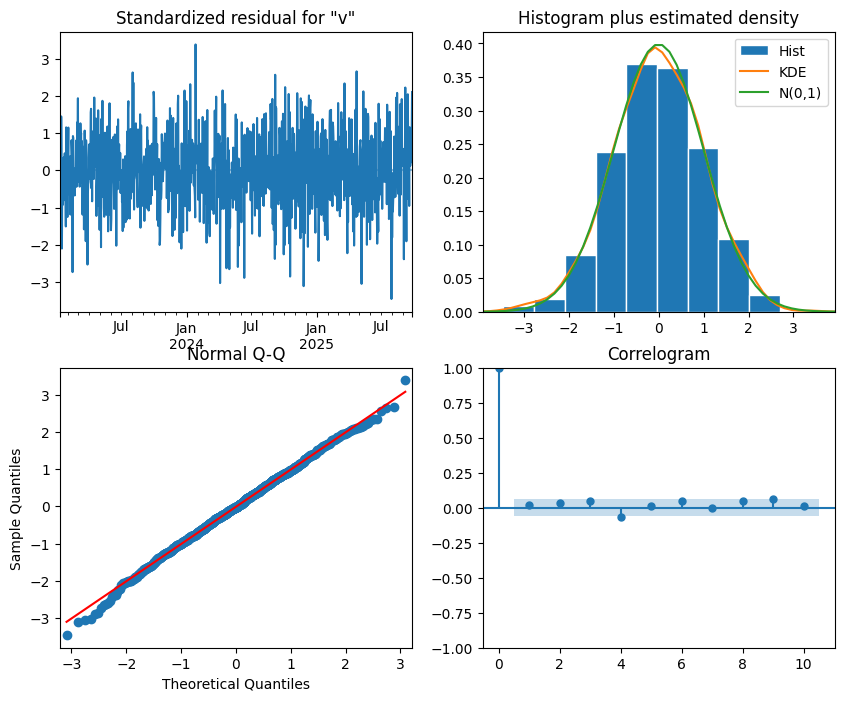

In [58]:
sarima_fit_011_111_7.plot_diagnostics(figsize=(10, 8))
plt.show()

## Analisi del Modello SARIMA(0,1,1)x(0,1,2,7)

In [59]:
sarima_011_012_7 = sm.tsa.SARIMAX(data, order=(0,1,1), seasonal_order=(0,1,2,7))
sarima_fit_011_012_7 = sarima_011_012_7.fit()
print(sarima_fit_011_012_7.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                                  value   No. Observations:                 1000
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -1425.431
Date:                                Tue, 30 Sep 2025   AIC                           2858.862
Time:                                        14:36:20   BIC                           2878.461
Sample:                                    01-01-2023   HQIC                          2866.314
                                         - 09-26-2025                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9990      0.039    -25.495      0.000      -1.076      -0.922
ma.

### Test dei Residui per SARIMA(0,1,1)x(0,1,2,7)

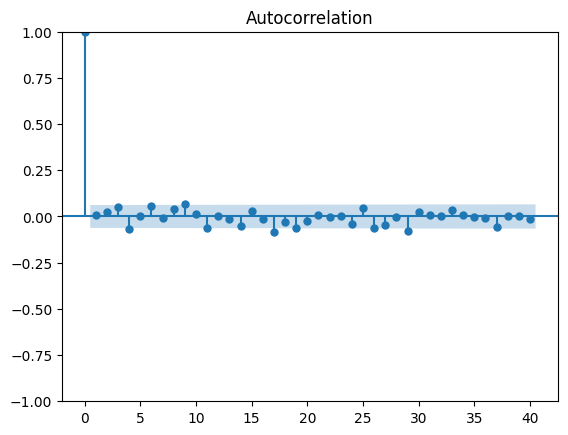

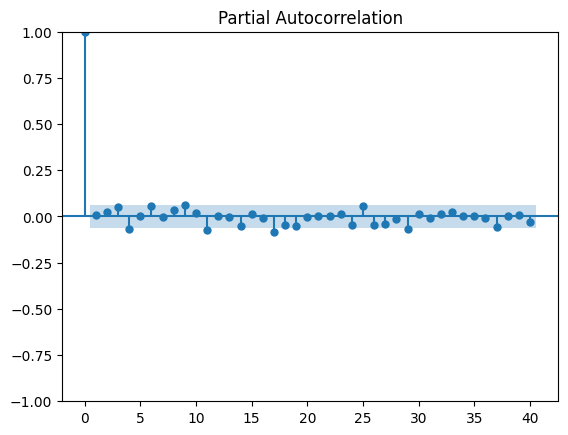

      lb_stat  lb_pvalue
10  17.758725   0.059173
20  38.430225   0.007842
30  56.385148   0.002465


In [60]:
residuals_sarima_011_012_7 = sarima_fit_011_012_7.resid
plot_acf(residuals_sarima_011_012_7, lags = 40)
plot_pacf(residuals_sarima_011_012_7, lags = 40)
plt.show()
lb_sarima_011_012_7  = acorr_ljungbox(residuals_sarima_011_012_7 , lags = [10,20,30], return_df = True)
print(lb_sarima_011_012_7)

## Analisi del Modello SARIMA(0,1,4)x(0,1,1,7)

In [61]:
sarima_014_011_7 = sm.tsa.SARIMAX(data, order=(0,1,4), seasonal_order=(0,1,1,7))
sarima_fit_014_011_7 = sarima_014_011_7.fit()
print(sarima_fit_014_011_7.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                 1000
Model:             SARIMAX(0, 1, 4)x(0, 1, [1], 7)   Log Likelihood               -1423.409
Date:                             Tue, 30 Sep 2025   AIC                           2858.818
Time:                                     14:36:29   BIC                           2888.217
Sample:                                 01-01-2023   HQIC                          2869.996
                                      - 09-26-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9763      0.183     -5.325      0.000      -1.336      -0.617
ma.L2          0.0168      

### Test dei Residui per SARIMA(0,1,4)x(0,1,1,7)

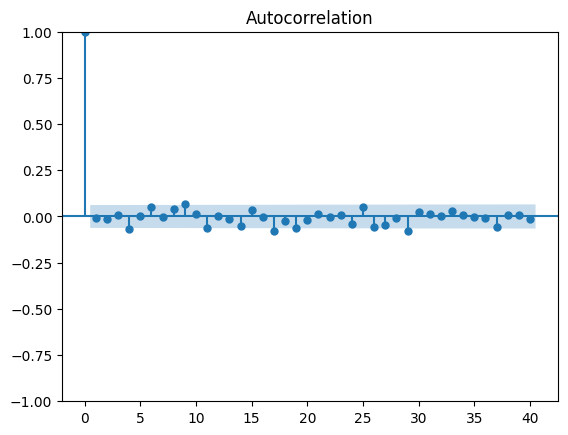

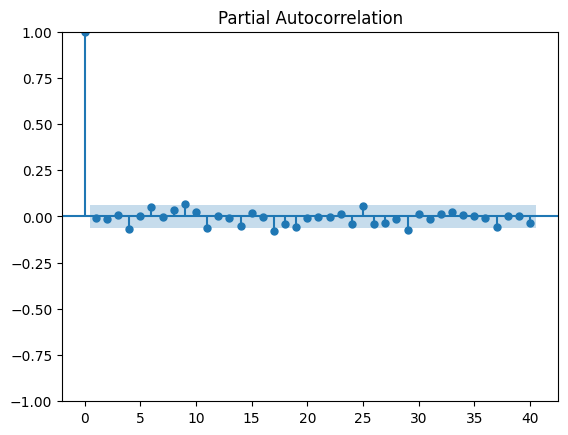

      lb_stat  lb_pvalue
10  14.344096   0.157867
20  33.661055   0.028511
30  50.692504   0.010497


In [62]:
residuals_sarima_014_011_7 = sarima_fit_014_011_7.resid
plot_acf(residuals_sarima_014_011_7, lags = 40)
plot_pacf(residuals_sarima_014_011_7, lags = 40)
plt.show()
lb_sarima_014_011_7  = acorr_ljungbox(residuals_sarima_014_011_7 , lags = [10,20,30], return_df = True)
print(lb_sarima_014_011_7)

## Analisi del Modello SARIMA(4,1,0)x(0,1,1,7)

In [63]:
sarima_410_011_7 = sm.tsa.SARIMAX(data, order=(4,1,0), seasonal_order=(0,1,1,7))
sarima_fit_410_011_7 = sarima_410_011_7.fit()
print(sarima_fit_410_011_7.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                 1000
Model:             SARIMAX(4, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -1504.097
Date:                             Tue, 30 Sep 2025   AIC                           3020.194
Time:                                     14:36:31   BIC                           3049.593
Sample:                                 01-01-2023   HQIC                          3031.372
                                      - 09-26-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7778      0.031    -24.762      0.000      -0.839      -0.716
ar.L2         -0.5565      

### Test dei Residui per SARIMA(4,1,0)x(0,1,1,7)

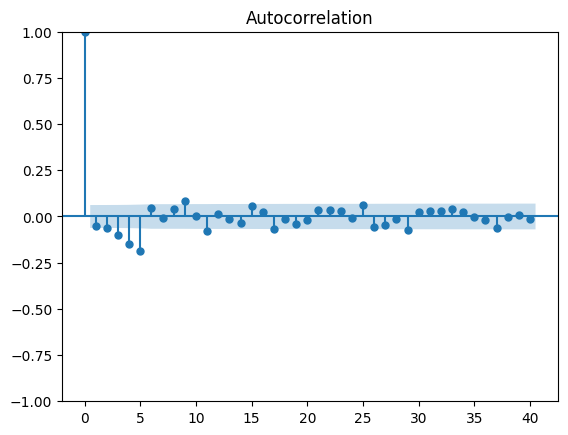

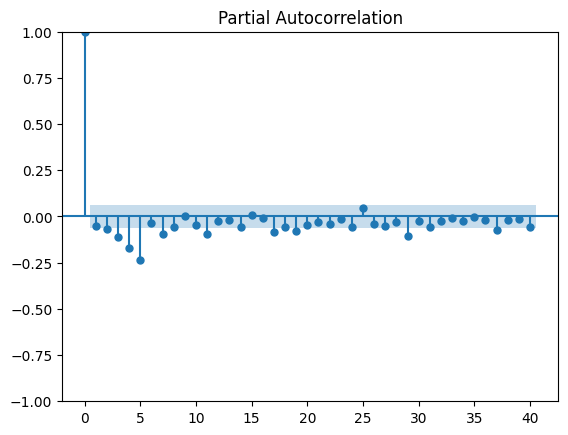

       lb_stat     lb_pvalue
10   88.072562  1.290169e-14
20  106.986764  6.937280e-14
30  125.649210  1.137889e-13


In [64]:
residuals_sarima_410_011_7 = sarima_fit_410_011_7.resid
plot_acf(residuals_sarima_410_011_7, lags = 40)
plot_pacf(residuals_sarima_410_011_7, lags = 40)
plt.show()
lb_sarima_410_011_7  = acorr_ljungbox(residuals_sarima_410_011_7 , lags = [10,20,30], return_df = True)
print(lb_sarima_410_011_7)

## Analisi del Modello SARIMA(2,1,0)x(0,1,1,7)

In [65]:
sarima_210_011_7 = sm.tsa.SARIMAX(data, order=(2,1,0), seasonal_order=(0,1,1,7))
sarima_fit_210_011_7 = sarima_210_011_7.fit()
print(sarima_fit_210_011_7.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                 1000
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -1540.934
Date:                             Tue, 30 Sep 2025   AIC                           3089.868
Time:                                     14:36:33   BIC                           3109.467
Sample:                                 01-01-2023   HQIC                          3097.320
                                      - 09-26-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6841      0.031    -22.221      0.000      -0.744      -0.624
ar.L2         -0.3445      

### Test dei Residui per SARIMA(2,1,0)x(0,1,1,7)

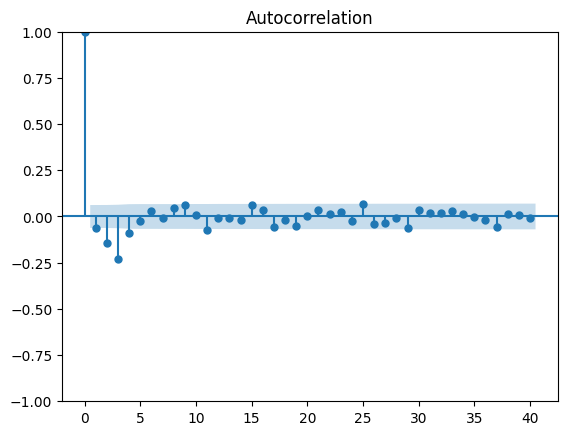

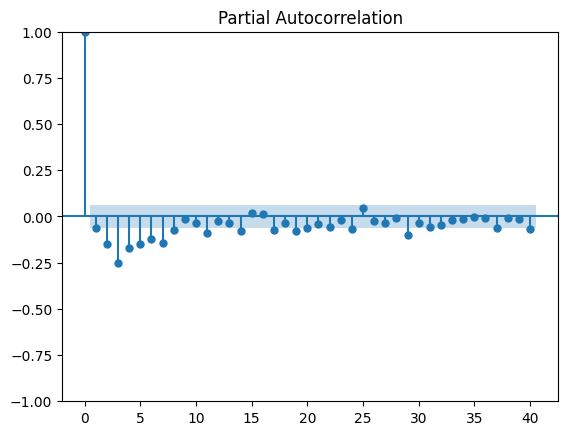

       lb_stat     lb_pvalue
10   93.674932  9.971899e-16
20  110.856414  1.370488e-14
30  126.634973  7.738152e-14


In [66]:
residuals_sarima_210_011_7 = sarima_fit_210_011_7.resid
plot_acf(residuals_sarima_210_011_7, lags = 40)
plot_pacf(residuals_sarima_210_011_7, lags = 40)
plt.show()
lb_sarima_210_011_7  = acorr_ljungbox(residuals_sarima_210_011_7 , lags = [10,20,30], return_df = True)
print(lb_sarima_210_011_7)

## Analisi del Modello SARIMA(1,1,0)x(0,1,1,7)

In [67]:
sarima_110_011_7 = sm.tsa.SARIMAX(data, order=(1,1,0), seasonal_order=(0,1,1,7))
sarima_fit_110_011_7 = sarima_110_011_7.fit()
print(sarima_fit_110_011_7.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                 1000
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -1603.648
Date:                             Tue, 30 Sep 2025   AIC                           3213.297
Time:                                     14:36:35   BIC                           3227.996
Sample:                                 01-01-2023   HQIC                          3218.886
                                      - 09-26-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5083      0.027    -18.807      0.000      -0.561      -0.455
ma.S.L7       -0.9853      

### Test dei Residui per SARIMA(1,1,0)x(0,1,1,7)

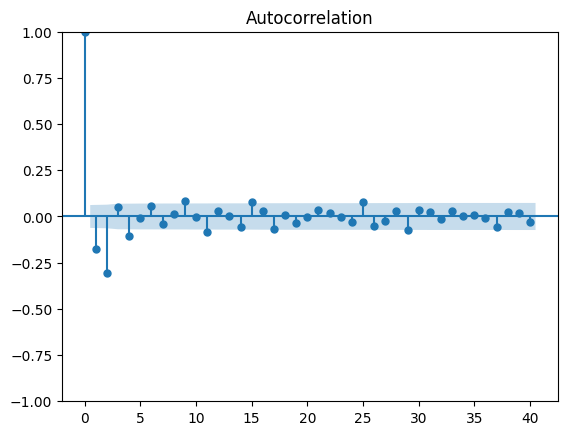

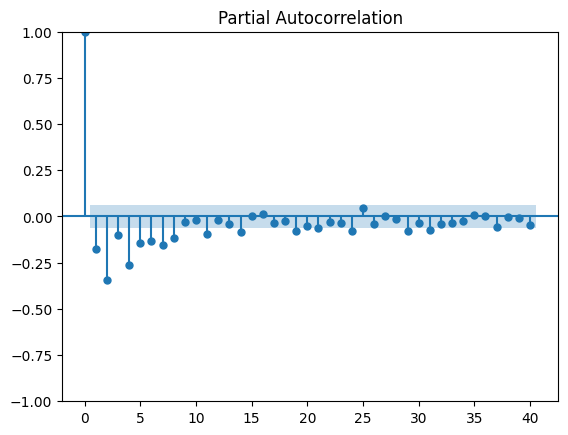

       lb_stat     lb_pvalue
10  150.338303  3.175516e-27
20  175.046040  9.017416e-27
30  194.747812  4.735872e-26


In [68]:
residuals_sarima_110_011_7 = sarima_fit_110_011_7.resid
plot_acf(residuals_sarima_110_011_7, lags = 40)
plot_pacf(residuals_sarima_110_011_7, lags = 40)
plt.show()
lb_sarima_110_011_7  = acorr_ljungbox(residuals_sarima_110_011_7 , lags = [10,20,30], return_df = True)
print(lb_sarima_110_011_7)

## Analisi del Modello SARIMA(1,1,2)x(0,1,1,7)

In [69]:
sarima_112_011_7 = sm.tsa.SARIMAX(data, order=(1,1,2), seasonal_order=(0,1,1,7))
sarima_fit_112_011_7 = sarima_112_011_7.fit()
print(sarima_fit_112_011_7.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                 1000
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -1425.075
Date:                             Tue, 30 Sep 2025   AIC                           2860.150
Time:                                     14:36:42   BIC                           2884.648
Sample:                                 01-01-2023   HQIC                          2869.465
                                      - 09-26-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7243      0.640     -1.132      0.258      -1.979       0.530
ma.L1         -0.2586      

### Test dei Residui per SARIMA(1,1,2)x(0,1,1,7)

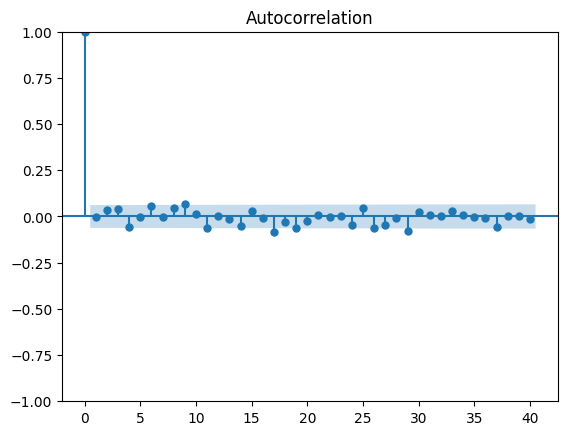

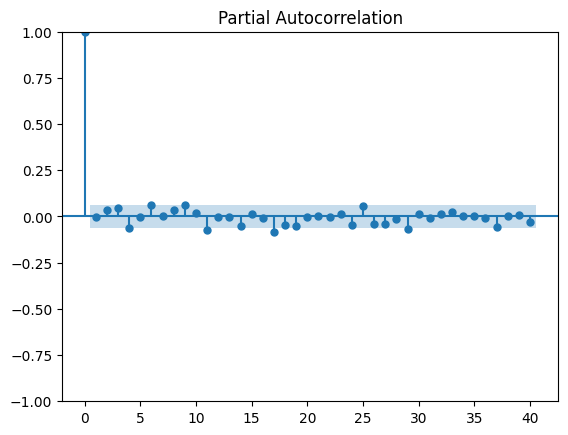

      lb_stat  lb_pvalue
10  16.936197   0.075788
20  37.604141   0.009895
30  55.705235   0.002951


In [70]:
residuals_sarima_112_011_7 = sarima_fit_112_011_7.resid
plot_acf(residuals_sarima_112_011_7, lags = 40)
plot_pacf(residuals_sarima_112_011_7, lags = 40)
plt.show()
lb_sarima_112_011_7  = acorr_ljungbox(residuals_sarima_112_011_7 , lags = [10,20,30], return_df = True)
print(lb_sarima_112_011_7)

## Analisi del Modello SARIMA(1,1,1)x(1,1,1,7)

In [71]:
sarima_111_111_7 = sm.tsa.SARIMAX(data, order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_fit_111_111_7 = sarima_111_111_7.fit()
print(sarima_fit_111_111_7.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                 1000
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1425.276
Date:                           Tue, 30 Sep 2025   AIC                           2860.552
Time:                                   14:36:45   BIC                           2885.051
Sample:                               01-01-2023   HQIC                          2869.867
                                    - 09-26-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0183      0.031      0.586      0.558      -0.043       0.080
ma.L1         -0.9995      0.082    -12.135

### Test dei Residui per SARIMA(1,1,1)x(1,1,1,7)

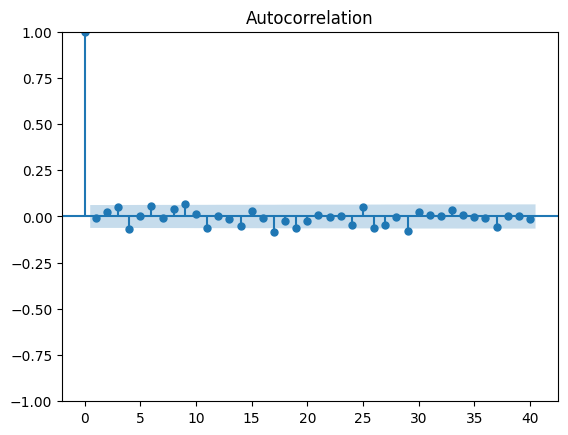

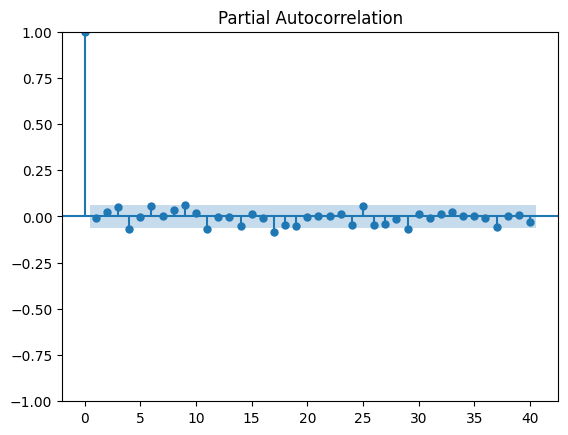

      lb_stat  lb_pvalue
10  17.643130   0.061290
20  38.052679   0.008725
30  56.315722   0.002511


In [72]:
residuals_sarima_111_111_7 = sarima_fit_111_111_7.resid
plot_acf(residuals_sarima_111_111_7, lags = 40)
plot_pacf(residuals_sarima_111_111_7, lags = 40)
plt.show()
lb_sarima_111_111_7  = acorr_ljungbox(residuals_sarima_111_111_7 , lags = [10,20,30], return_df = True)
print(lb_sarima_111_111_7)

## Analisi del Modello SARIMA(1,1,1)x(0,1,1,7)

In [73]:
sarima_111_011_7 = sm.tsa.SARIMAX(data, order=(1,1,1), seasonal_order=(0,1,1,7))
sarima_fit_111_011_7 = sarima_111_011_7.fit()
print(sarima_fit_111_011_7.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                 1000
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1425.315
Date:                           Tue, 30 Sep 2025   AIC                           2858.629
Time:                                   14:36:49   BIC                           2878.228
Sample:                               01-01-2023   HQIC                          2866.081
                                    - 09-26-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0196      0.031      0.627      0.531      -0.042       0.081
ma.L1         -0.9995      0.076    -13.078

### Test dei Residui per SARIMA(1,1,1)x(0,1,1,7)

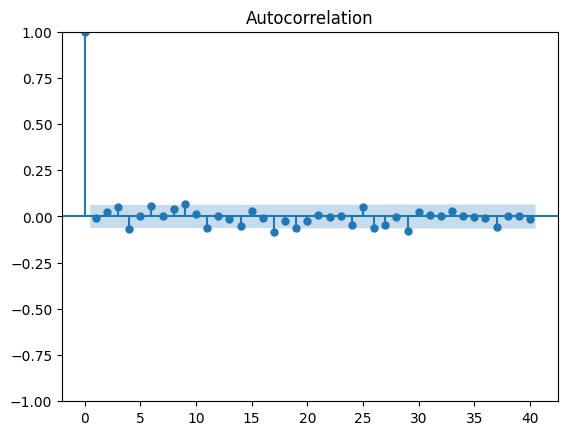

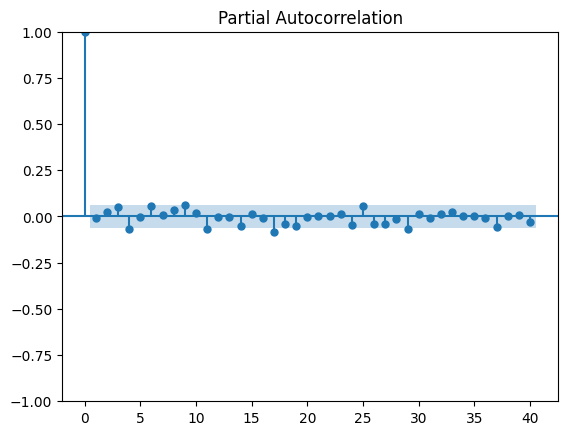

      lb_stat  lb_pvalue
10  17.599520   0.062107
20  38.217977   0.008328
30  56.598568   0.002329


In [74]:
residuals_sarima_111_011_7 = sarima_fit_111_011_7.resid
plot_acf(residuals_sarima_111_011_7, lags = 40)
plot_pacf(residuals_sarima_111_011_7, lags = 40)
plt.show()
lb_sarima_111_011_7  = acorr_ljungbox(residuals_sarima_111_011_7 , lags = [10,20,30], return_df = True)
print(lb_sarima_111_011_7)

## Analisi del Modello SARIMA(0,0,3)x(0,1,1,7)

In [75]:
sarima_003_011_7 = sm.tsa.SARIMAX(data, order=(0,0,3), seasonal_order=(0,1,1,7))
sarima_fit_003_011_7 = sarima_003_011_7.fit()
print(sarima_fit_003_011_7.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                 1000
Model:             SARIMAX(0, 0, 3)x(0, 1, [1], 7)   Log Likelihood               -1437.371
Date:                             Tue, 30 Sep 2025   AIC                           2884.741
Time:                                     14:36:50   BIC                           2909.245
Sample:                                 01-01-2023   HQIC                          2894.058
                                      - 09-26-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0422      0.031      1.368      0.171      -0.018       0.103
ma.L2          0.0628      

### Test dei Residui per SARIMA(0,0,3)x(0,1,1,7)

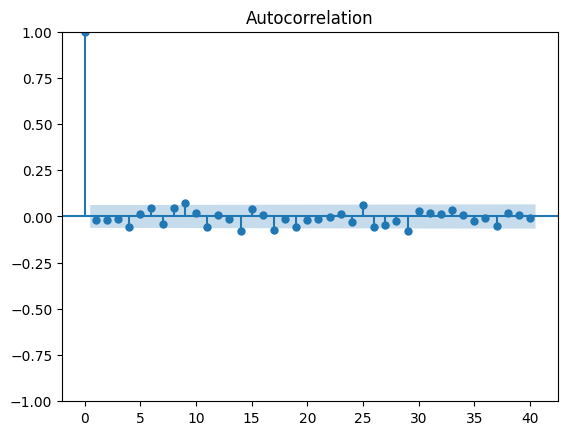

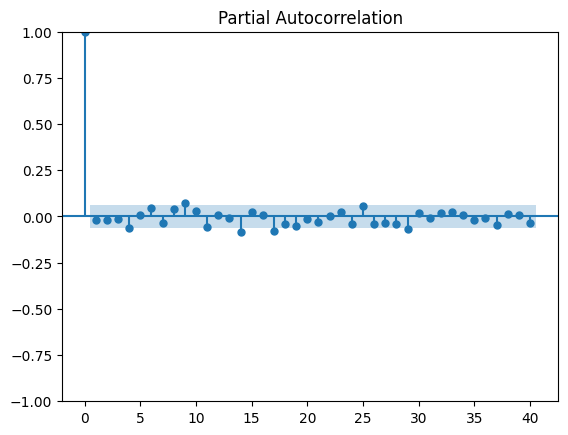

      lb_stat  lb_pvalue
10  15.832520   0.104528
20  36.147804   0.014777
30  54.468107   0.004075


In [76]:
residuals_sarima_003_011_7 = sarima_fit_003_011_7.resid
plot_acf(residuals_sarima_003_011_7, lags = 40)
plot_pacf(residuals_sarima_003_011_7, lags = 40)
plt.show()
lb_sarima_003_011_7  = acorr_ljungbox(residuals_sarima_003_011_7 , lags = [10,20,30], return_df = True)
print(lb_sarima_003_011_7)

## Analisi del Modello SARIMA(0,0,2)x(0,1,1,7)

In [77]:
sarima_002_011_7 = sm.tsa.SARIMAX(data, order=(0,0,2), seasonal_order=(0,1,1,7))
sarima_fit_002_011_7 = sarima_002_011_7.fit()
print(sarima_fit_002_011_7.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                 1000
Model:             SARIMAX(0, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -1440.079
Date:                             Tue, 30 Sep 2025   AIC                           2888.158
Time:                                     14:36:51   BIC                           2907.761
Sample:                                 01-01-2023   HQIC                          2895.611
                                      - 09-26-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0294      0.031      0.947      0.344      -0.031       0.090
ma.L2          0.0640      

### Test dei Residui per SARIMA(0,0,2)x(0,1,1,7)

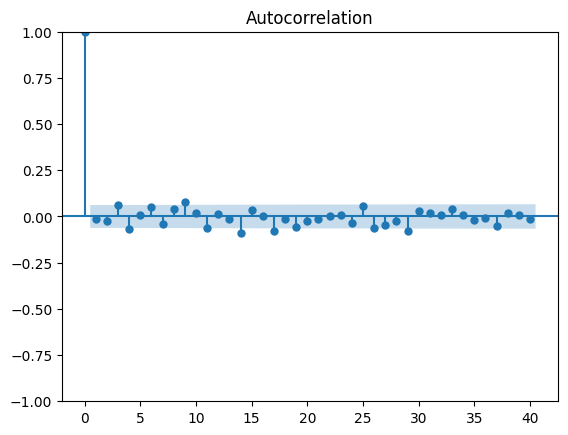

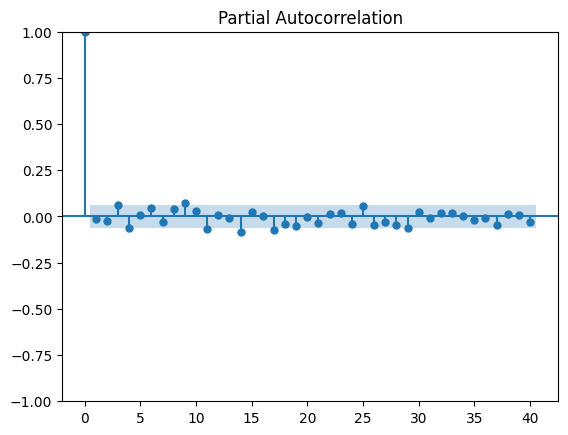

      lb_stat  lb_pvalue
10  21.060059   0.020679
20  44.639808   0.001235
30  63.761389   0.000315


In [78]:
residuals_sarima_002_011_7 = sarima_fit_002_011_7.resid
plot_acf(residuals_sarima_002_011_7, lags = 40)
plot_pacf(residuals_sarima_002_011_7, lags = 40)
plt.show()
lb_sarima_002_011_7  = acorr_ljungbox(residuals_sarima_002_011_7 , lags = [10,20,30], return_df = True)
print(lb_sarima_002_011_7)

## Analisi del Modello SARIMA(0,1,1)x(0,1,0,15)

In [79]:
sarima_011_010_15 = sm.tsa.SARIMAX(data, order=(0,1,1), seasonal_order=(0,1,0,15))
sarima_fit_011_010_15 = sarima_011_010_15.fit()
print(sarima_fit_011_010_15.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                 1000
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 15)   Log Likelihood               -1718.860
Date:                             Tue, 30 Sep 2025   AIC                           3441.720
Time:                                     14:36:54   BIC                           3451.503
Sample:                                 01-01-2023   HQIC                          3445.441
                                      - 09-26-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9994      0.046    -21.722      0.000      -1.090      -0.909
sigma2         1.9141      

### Test dei Residui per SARIMA(0,1,1)x(0,1,0,15)

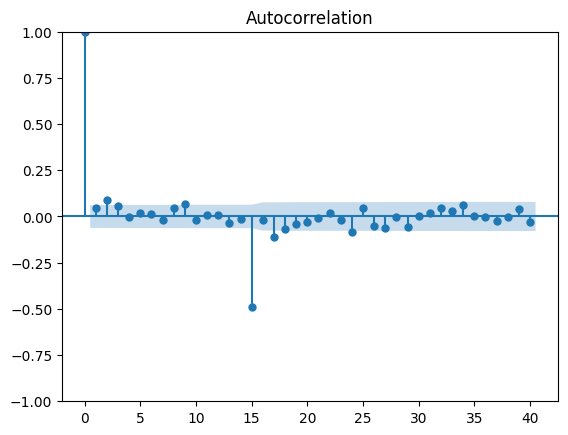

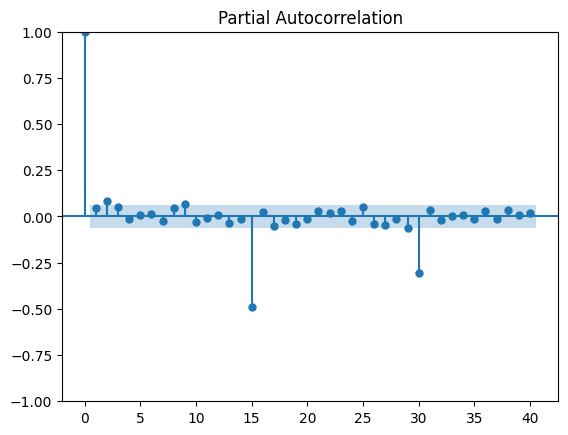

       lb_stat     lb_pvalue
10   20.777845  2.269704e-02
20  286.011967  5.750839e-49
30  305.944471  1.780514e-47


In [80]:
residuals_sarima_011_010_15 = sarima_fit_011_010_15.resid
plot_acf(residuals_sarima_011_010_15, lags = 40)
plot_pacf(residuals_sarima_011_010_15, lags = 40)
plt.show()
lb_sarima_011_010_15  = acorr_ljungbox(residuals_sarima_011_010_15 , lags = [10,20,30], return_df = True)
print(lb_sarima_011_010_15)

## Analisi del Modello SARIMA(0,1,1)x(1,1,0,15)

In [81]:
sarima_011_110_15 = sm.tsa.SARIMAX(data, order=(0,1,1), seasonal_order=(1,1,0,15))
sarima_fit_011_110_15 = sarima_011_110_15.fit()
print(sarima_fit_011_110_15.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                 1000
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 15)   Log Likelihood               -1581.769
Date:                             Tue, 30 Sep 2025   AIC                           3169.537
Time:                                     14:36:58   BIC                           3184.212
Sample:                                 01-01-2023   HQIC                          3175.119
                                      - 09-26-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9997      0.068    -14.685      0.000      -1.133      -0.866
ar.S.L15      -0.4947      

### Test dei Residui per SARIMA(0,1,1)x(1,1,0,15)

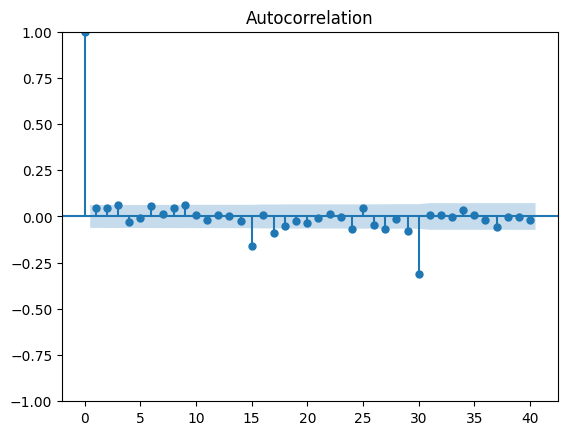

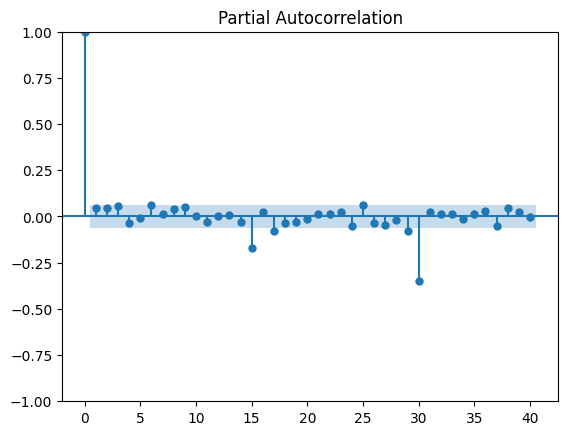

       lb_stat     lb_pvalue
10   18.721676  4.394359e-02
20   60.140230  6.774465e-06
30  181.998392  1.089496e-23


In [82]:
residuals_sarima_011_110_15 = sarima_fit_011_110_15.resid
plot_acf(residuals_sarima_011_110_15, lags = 40)
plot_pacf(residuals_sarima_011_110_15, lags = 40)
plt.show()
lb_sarima_011_110_15  = acorr_ljungbox(residuals_sarima_011_110_15 , lags = [10,20,30], return_df = True)
print(lb_sarima_011_110_15)

## Analisi del Modello SARIMA(0,1,1)x(1,1,1,15)

In [83]:
sarima_011_111_15 = sm.tsa.SARIMAX(data, order=(0,1,1), seasonal_order=(1,1,1,15))
sarima_fit_011_111_15 = sarima_011_111_15.fit()
print(sarima_fit_011_111_15.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                 1000
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 15)   Log Likelihood               -1418.367
Date:                            Tue, 30 Sep 2025   AIC                           2844.735
Time:                                    14:37:07   BIC                           2864.301
Sample:                                01-01-2023   HQIC                          2852.177
                                     - 09-26-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9996      0.110     -9.082      0.000      -1.215      -0.784
ar.S.L15       0.0149      0.032   

### Test dei Residui per SARIMA(0,1,1)x(1,1,1,15)

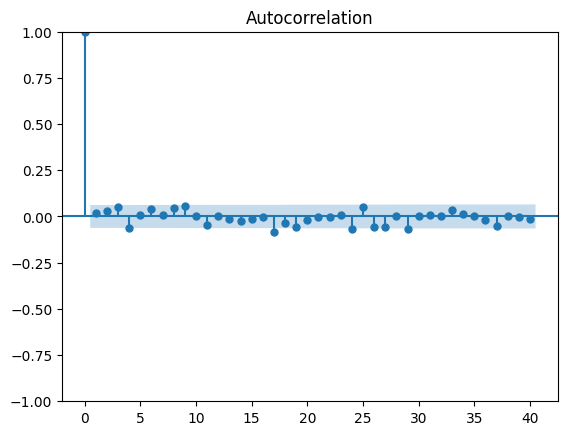

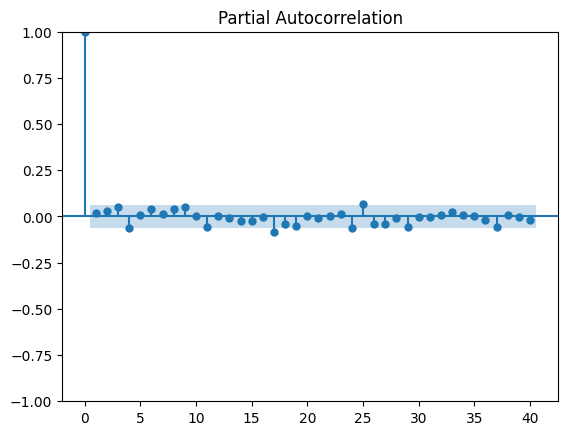

      lb_stat  lb_pvalue
10  14.790825   0.139876
20  30.439741   0.063035
30  49.032843   0.015597


In [84]:
residuals_sarima_011_111_15 = sarima_fit_011_111_15.resid
plot_acf(residuals_sarima_011_111_15, lags = 40)
plot_pacf(residuals_sarima_011_111_15, lags = 40)
plt.show()
lb_sarima_011_111_15  = acorr_ljungbox(residuals_sarima_011_111_15 , lags = [10,20,30], return_df = True)
print(lb_sarima_011_111_15)

Analisi del Modello SARIMA(0,0,0)x(0,1,1,30)

In [85]:
sarima_000_011_30 = sm.tsa.SARIMAX(data, order=(0,0,0), seasonal_order=(0,1,1,30))
sarima_fit_000_011_30 = sarima_000_011_30.fit()
print(sarima_fit_000_011_30.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:                      value   No. Observations:                 1000
Model:             SARIMAX(0, 1, [1], 30)   Log Likelihood               -1458.804
Date:                    Tue, 30 Sep 2025   AIC                           2921.608
Time:                            14:37:12   BIC                           2931.362
Sample:                        01-01-2023   HQIC                          2925.321
                             - 09-26-2025                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L30      -0.7883      0.023    -34.975      0.000      -0.833      -0.744
sigma2         1.1502      0.054     21.328      0.000       1.044       1.256
Ljung-Box (L1) (Q): 

Test dei Residui per SARIMA(0,0,0)x(,1,1,30)

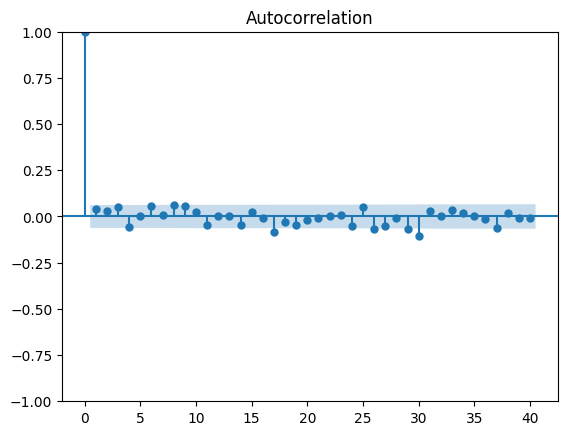

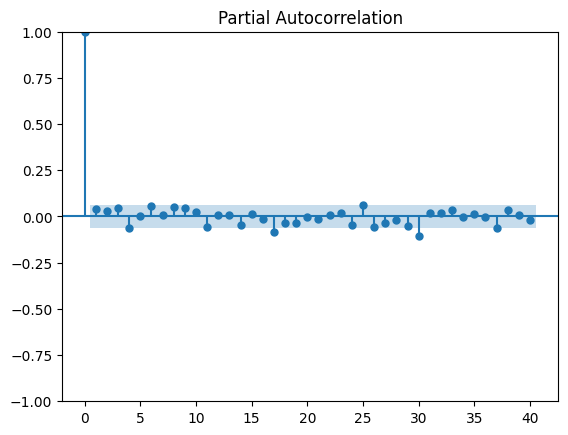

      lb_stat  lb_pvalue
10  19.094787   0.039075
20  34.691693   0.021809
30  64.099203   0.000286


In [86]:
residuals_sarima_000_011_30 = sarima_fit_000_011_30.resid
plot_acf(residuals_sarima_000_011_30, lags = 40)
plot_pacf(residuals_sarima_000_011_30, lags = 40)
plt.show()
lb_sarima_000_011_30  = acorr_ljungbox(residuals_sarima_000_011_30 , lags = [10,20,30], return_df = True)
print(lb_sarima_000_011_30)

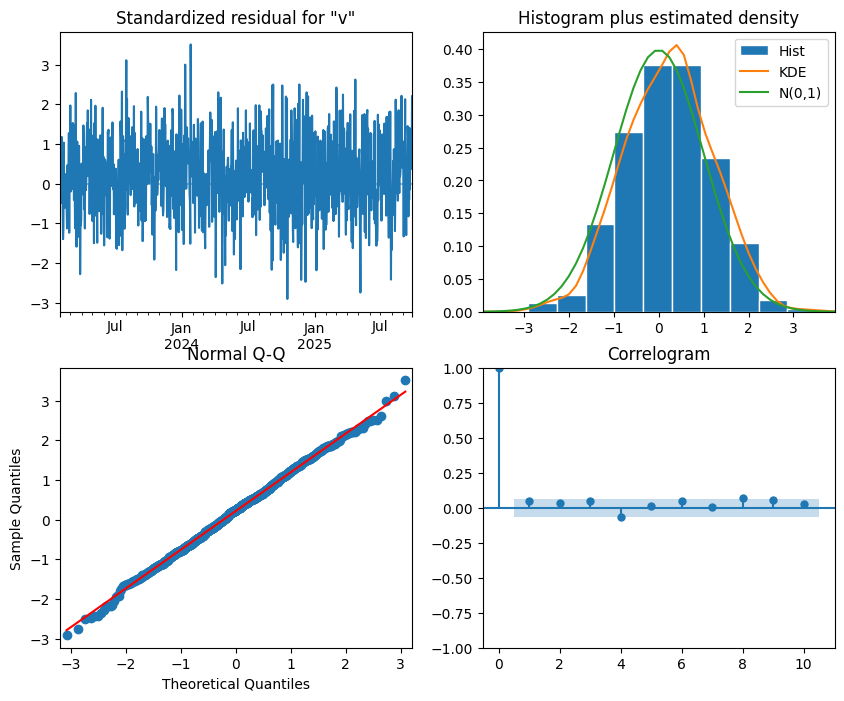

In [87]:
sarima_fit_000_011_30.plot_diagnostics(figsize=(10, 8))
plt.show()

## Analisi del Modello SARIMA(0,0,0)x(1,1,1,30)

In [88]:
sarima_000_111_30 = sm.tsa.SARIMAX(data, order=(0,0,0), seasonal_order=(1,1,1,30))
sarima_fit_000_111_30 = sarima_000_111_30.fit()
print(sarima_fit_000_111_30.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:                      value   No. Observations:                 1000
Model:             SARIMAX(1, 1, [1], 30)   Log Likelihood               -1457.800
Date:                    Tue, 30 Sep 2025   AIC                           2921.599
Time:                            14:37:21   BIC                           2936.231
Sample:                        01-01-2023   HQIC                          2927.169
                             - 09-26-2025                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L30      -0.0563      0.042     -1.325      0.185      -0.139       0.027
ma.S.L30      -0.7684      0.030    -25.694      0.000      -0.827      -0.710
sigma2         1.147

### Test dei Residui per SARIMA(0,0,0)x(1,1,1,30)

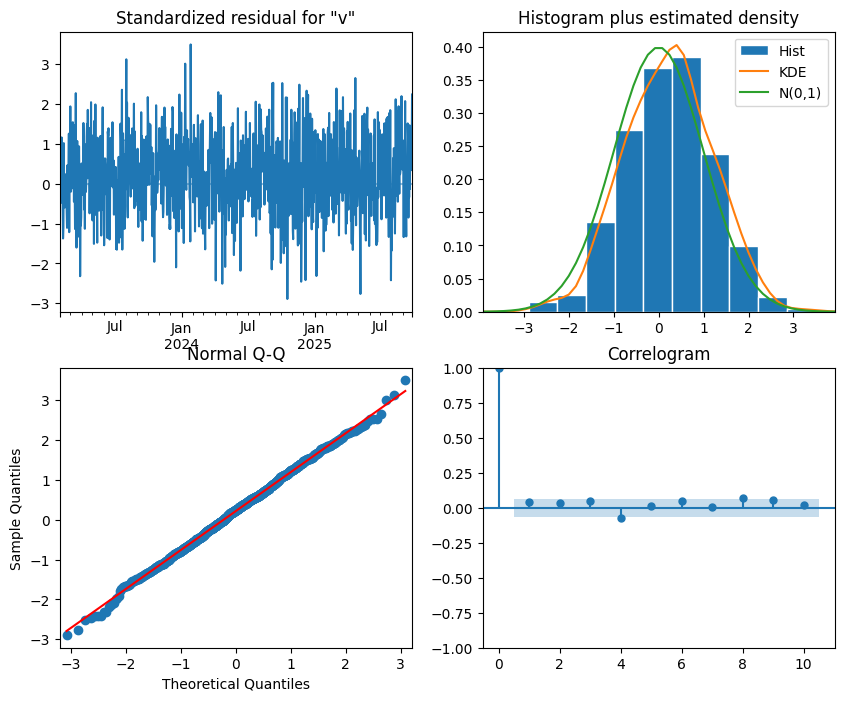

In [89]:
sarima_fit_000_111_30.plot_diagnostics(figsize=(10, 8))
plt.show()

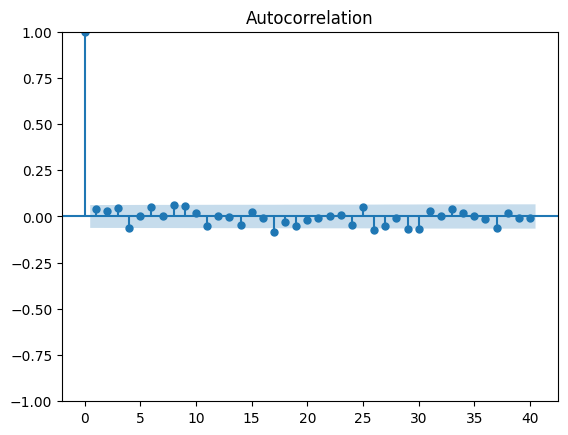

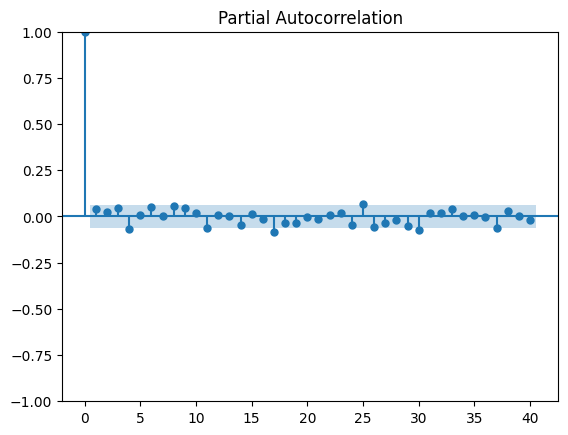

      lb_stat  lb_pvalue
10  19.034994   0.039820
20  35.033345   0.019927
30  57.907065   0.001638


In [90]:
residuals_sarima_000_111_30 = sarima_fit_000_111_30.resid
plot_acf(residuals_sarima_000_111_30, lags = 40)
plot_pacf(residuals_sarima_000_111_30, lags = 40)
plt.show()
lb_sarima_000_111_30  = acorr_ljungbox(residuals_sarima_000_111_30 , lags = [10,20,30], return_df = True)
print(lb_sarima_000_111_30)

## Analisi del Modello SARIMA(0,1,1)x(0,1,0,30)

In [91]:
sarima_011_010_30 = sm.tsa.SARIMAX(data, order=(0,1,1), seasonal_order=(0,1,0,30))
sarima_fit_011_010_30 = sarima_011_010_30.fit()
print(sarima_fit_011_010_30.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                 1000
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 30)   Log Likelihood               -1697.379
Date:                             Tue, 30 Sep 2025   AIC                           3398.757
Time:                                     14:37:25   BIC                           3408.510
Sample:                                 01-01-2023   HQIC                          3402.469
                                      - 09-26-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9991      0.026    -38.614      0.000      -1.050      -0.948
sigma2         1.9332      

### Test dei Residui per SARIMA(0,1,1)x(0,1,0,30)

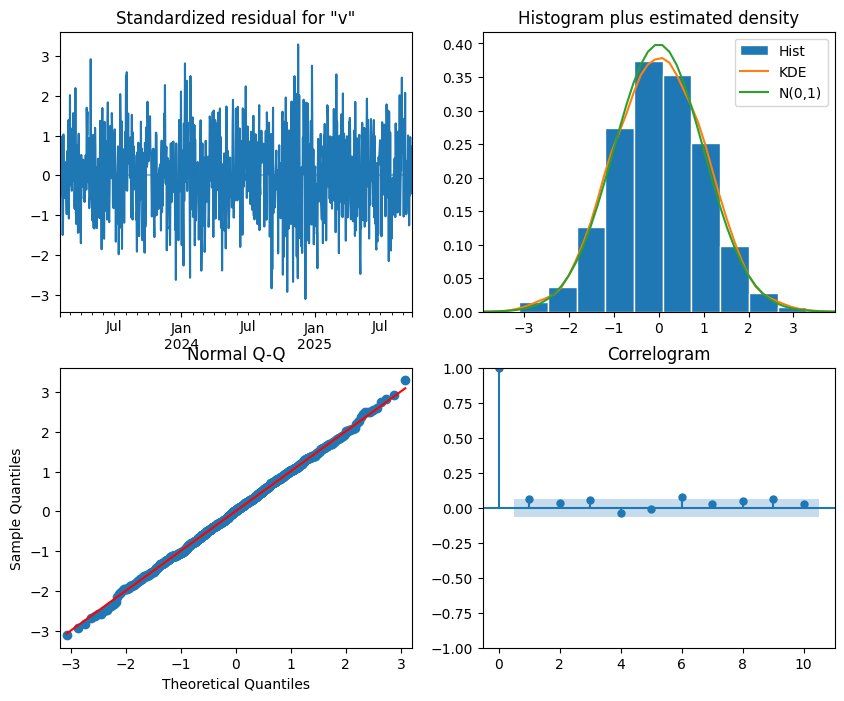

In [92]:
sarima_fit_011_010_30.plot_diagnostics(figsize=(10, 8))
plt.show()

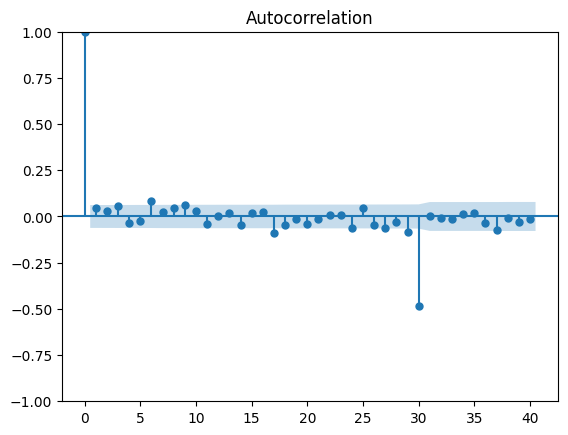

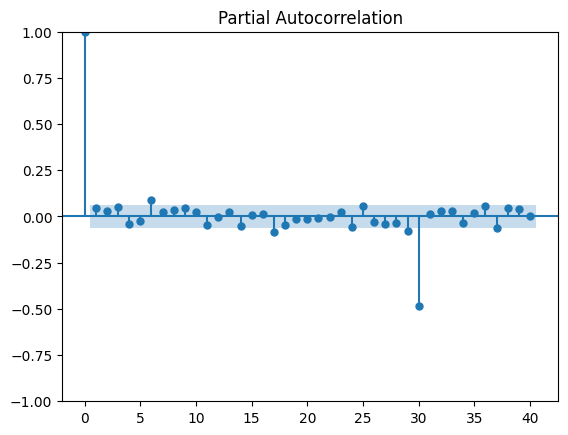

       lb_stat     lb_pvalue
10   22.111946  1.454435e-02
20   39.214664  6.269256e-03
30  303.841897  4.628946e-47


In [93]:
residuals_sarima_011_010_30 = sarima_fit_011_010_30.resid
plot_acf(residuals_sarima_011_010_30, lags = 40)
plot_pacf(residuals_sarima_011_010_30, lags = 40)
plt.show()
lb_sarima_011_010_30  = acorr_ljungbox(residuals_sarima_011_010_30 , lags = [10,20,30], return_df = True)
print(lb_sarima_011_010_30)

Analisi del Modello SARIMA(0,1,1)x(0,1,1,30)

In [94]:
sarima_011_011_30 = sm.tsa.SARIMAX(data, order=(0,1,1), seasonal_order=(0,1,1,30))
sarima_fit_011_011_30 = sarima_011_011_30.fit()
print(sarima_fit_011_011_30.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                 1000
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 30)   Log Likelihood               -1416.625
Date:                            Tue, 30 Sep 2025   AIC                           2839.251
Time:                                    14:37:42   BIC                           2853.880
Sample:                                01-01-2023   HQIC                          2844.819
                                     - 09-26-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9994      0.061    -16.323      0.000      -1.119      -0.879
ma.S.L30      -0.9979      0.553   

### Test dei Residui per SARIMA(0,1,1)x(0,1,1,30)

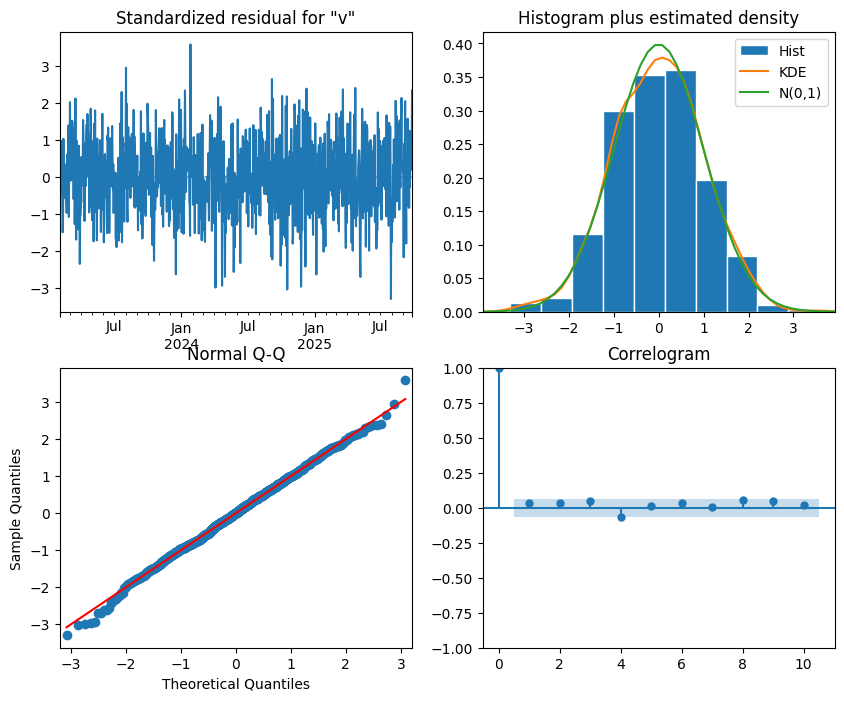

In [95]:
sarima_fit_011_011_30.plot_diagnostics(figsize=(10, 8))
plt.show()

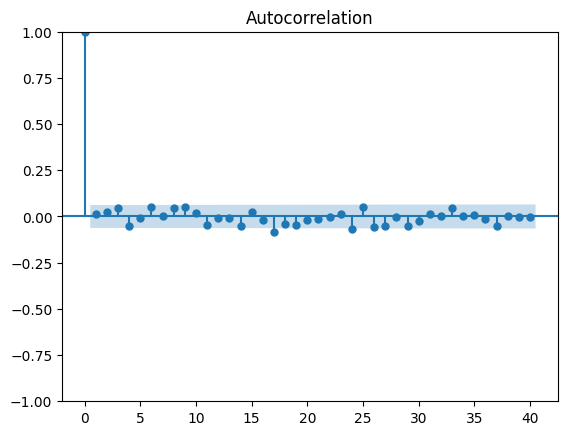

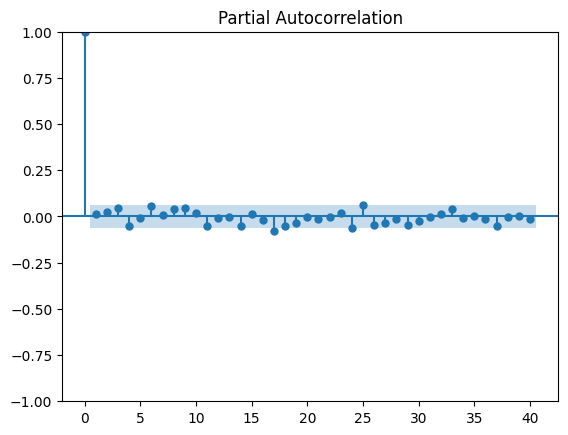

      lb_stat  lb_pvalue
10  13.131730   0.216400
20  30.244815   0.065983
30  47.410324   0.022682


In [96]:
residuals_sarima_011_011_30 = sarima_fit_011_011_30.resid
plot_acf(residuals_sarima_011_011_30, lags = 40)
plot_pacf(residuals_sarima_011_011_30, lags = 40)
plt.show()
lb_sarima_011_011_30  = acorr_ljungbox(residuals_sarima_011_011_30 , lags = [10,20,30], return_df = True)
print(lb_sarima_011_011_30)

## Analisi del Modello SARIMA(0,1,1)x(1,1,0,30)

In [97]:
sarima_011_110_30 = sm.tsa.SARIMAX(data, order=(0,1,1), seasonal_order=(1,1,0,30))
sarima_fit_011_110_30 = sarima_011_110_30.fit()
print(sarima_fit_011_110_30.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                 1000
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 30)   Log Likelihood               -1562.624
Date:                             Tue, 30 Sep 2025   AIC                           3131.248
Time:                                     14:38:08   BIC                           3145.877
Sample:                                 01-01-2023   HQIC                          3136.816
                                      - 09-26-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.582     -1.718      0.086      -2.141       0.141
ar.S.L30      -0.4961      

### Test dei Residui per SARIMA(0,1,1)x(1,1,0,30)

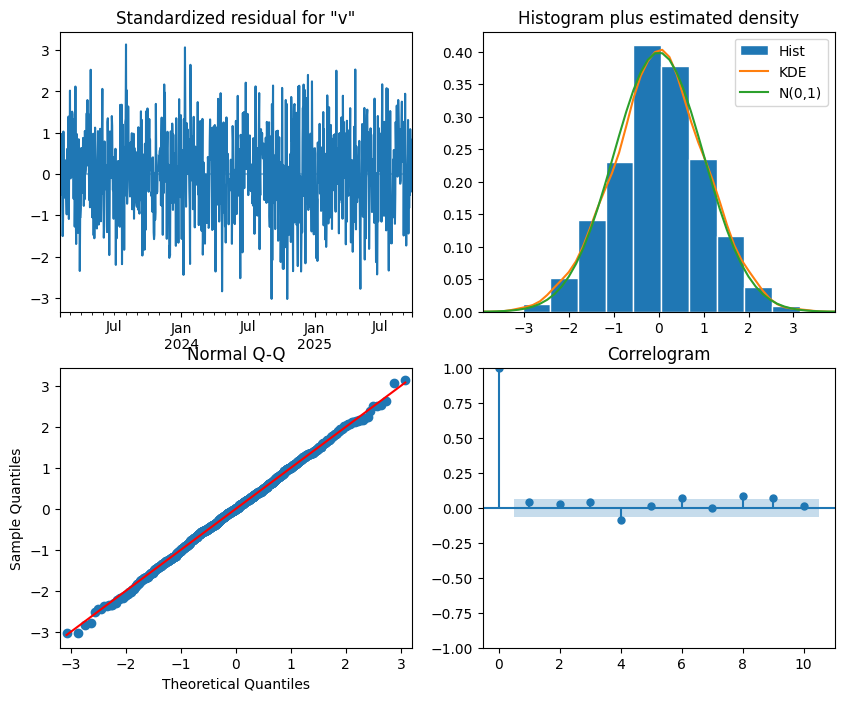

In [98]:
sarima_fit_011_110_30.plot_diagnostics(figsize=(10, 8))
plt.show()

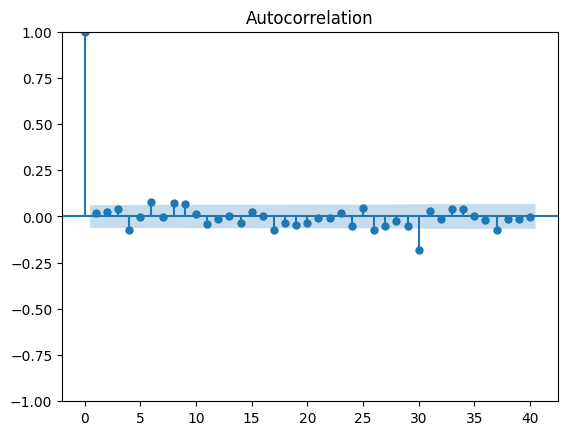

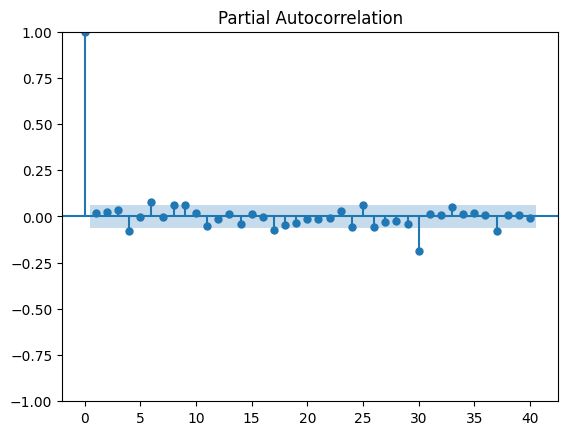

      lb_stat     lb_pvalue
10  24.170105  7.161458e-03
20  38.403543  7.902005e-03
30  89.622316  7.491919e-08


In [99]:
residuals_sarima_011_110_30 = sarima_fit_011_110_30.resid
plot_acf(residuals_sarima_011_110_30, lags = 40)
plot_pacf(residuals_sarima_011_110_30, lags = 40)
plt.show()
lb_sarima_011_110_30  = acorr_ljungbox(residuals_sarima_011_110_30 , lags = [10,20,30], return_df = True)
print(lb_sarima_011_110_30)

# Model selection

For each seasonality, the best models were chosen as follows:

- S=7: SARIMA(0,0,3)x(0,1,1,7), with imperfect but better residuals compared to other weekly models.

- S=15: SARIMA(0,1,1)x(0,1,1,15), characterized by a good compromise between low AIC/BIC and acceptable residuals.

- S=30: SARIMA(0,1,1)x(0,1,1,30), which presents the lowest AIC/BIC values and residuals close to randomness.

The comparison highlighted a superior performance for seasonalities 15 and 30 compared to the weekly one. Among the three, the model with S=30 is the most robust, thanks to better handling of autocorrelations at short and medium lags and the minimization of information criteria, despite imperfectly random residuals at lag 30 and a non-significant seasonal MA coefficient at 0.05%.

The forecasts show a good fit to the main trend and seasonality, with some local deviations.

Overall, the model with S=30 is configured as the best among those tested, although it does not necessarily represent the definitive solution.

The actual values have been compared with the values predicted by the models.

Per ciascuna stagionalità sono stati scelti come migliori i modelli:

- S=7: SARIMA(0,0,3)x(0,1,1,7), con residui non perfetti ma migliori rispetto agli altri modelli settimanali.

- S=15: SARIMA(0,1,1)x(0,1,1,15), caratterizzato da un buon compromesso tra AIC/BIC bassi e residui accettabili.

- S=30: SARIMA(0,1,1)x(0,1,1,30), che presenta i valori di AIC/BIC più bassi e residui prossimi alla casualità.

Il confronto ha evidenziato una performance superiore per le stagionalità 15 e 30 rispetto a quella settimanale. Tra i tre, il modello con S=30 risulta il più robusto, grazie alla migliore gestione delle autocorrelazioni ai lag brevi e medi e alla minimizzazione dei criteri di informazione, pur con residui non perfettamente casuali a lag 30 e un coefficiente MA stagionale non significativo allo 0.05%.

Le previsioni mostrano un buon adattamento al trend e alla stagionalità principali, con alcune deviazioni locali.

Nel complesso, il modello con S=30 si configura come il migliore tra quelli testati, sebbene non rappresenti necessariamente la soluzione definitiva.

Sono state messi a confronto i valori reali con quelli predetti dai modelli.

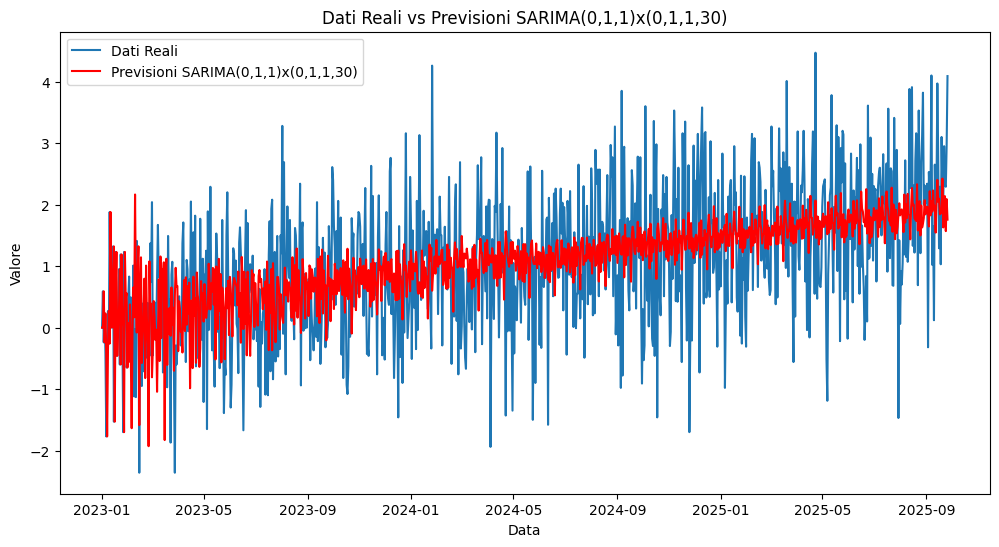

In [100]:
# Previsioni del modello SARIMA(0,1,1)x(0,1,1,30)
predictions = sarima_fit_011_011_30.predict(start=data.index[0], end=data.index[-1])

# Plot dei dati reali e delle previsioni
plt.figure(figsize=(12, 6))
plt.plot(data, label='Dati Reali')
plt.plot(predictions, color='red', label='Previsioni SARIMA(0,1,1)x(0,1,1,30)')
plt.title('Dati Reali vs Previsioni SARIMA(0,1,1)x(0,1,1,30)')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.legend()
plt.show()

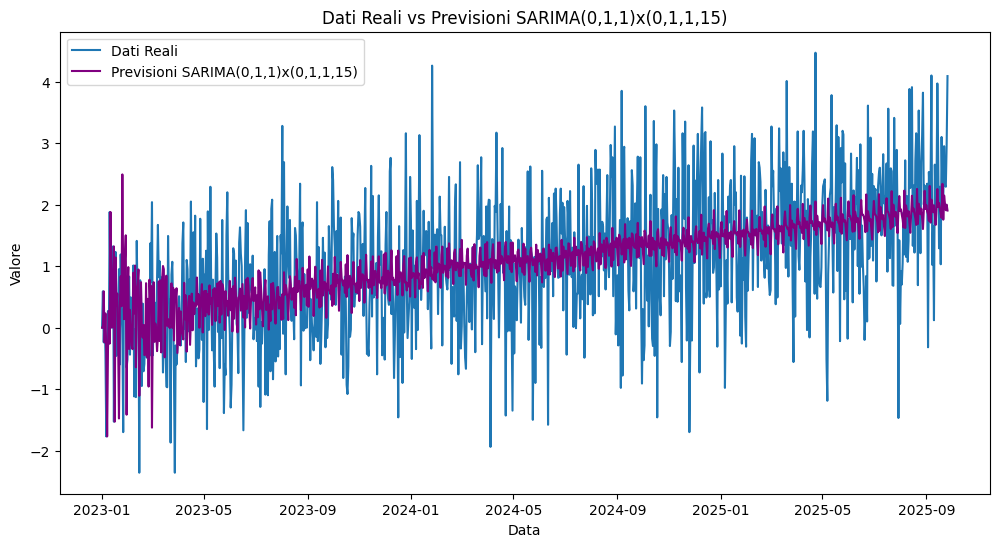

In [101]:
# Previsioni del modello SARIMA(0,1,1)x(0,1,1,15)
predictions_s15 = sarima_fit_011_011_15.predict(start=data.index[0], end=data.index[-1])

# Plot dei dati reali e delle previsioni per S=15
plt.figure(figsize=(12, 6))
plt.plot(data, label='Dati Reali')
plt.plot(predictions_s15, color='purple', label='Previsioni SARIMA(0,1,1)x(0,1,1,15)')
plt.title('Dati Reali vs Previsioni SARIMA(0,1,1)x(0,1,1,15)')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.legend()
plt.show()

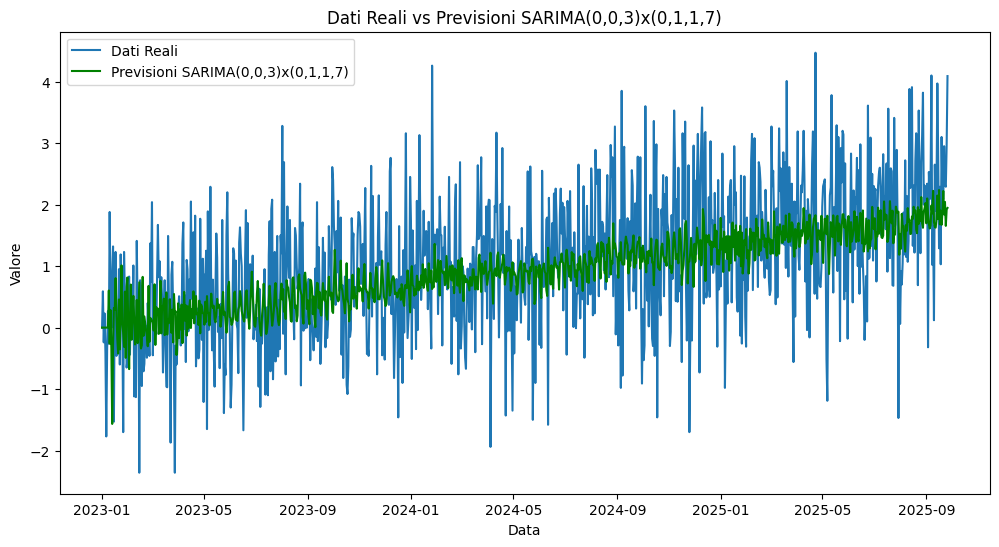

In [102]:
# Previsioni del modello SARIMA(0,0,3)x(0,1,1,7)
predictions_s7 = sarima_fit_003_011_7.predict(start=data.index[0], end=data.index[-1])

# Plot dei dati reali e delle previsioni per S=7
plt.figure(figsize=(12, 6))
plt.plot(data, label='Dati Reali')
plt.plot(predictions_s7, color='green', label='Previsioni SARIMA(0,0,3)x(0,1,1,7)')
plt.title('Dati Reali vs Previsioni SARIMA(0,0,3)x(0,1,1,7)')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.legend()
plt.show()